# Homework 3: Comparison of the Results of Different Classifiers

## Part 1. Import Packages

In [36]:
import pandas as pd
import numpy as np
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from datetime import datetime
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import hw3_pipeline as pipe
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 2. Import Data and Basic Explorations

Create the column 'over_60_days', which indicates that if the different between 'date_posted' and 'date_fullyfunded' is over 60 days

In [3]:
data = pipe.read_data('projects_2012_2013.csv')
data['date_posted'] = data['date_posted'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
data['datefullyfunded'] = data['datefullyfunded'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
data['over_60_days'] = data['datefullyfunded'] - data['date_posted']
data['over_60_days'] = data['over_60_days'].apply(lambda x: x.days)
data['over_60_days'] = data.apply(lambda row: pipe.label_to_dummy(row['over_60_days'], 60), axis=1)

Look at the summaries of the columns

In [4]:
data.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded',
       'over_60_days'],
      dtype='object')

In [5]:
data.describe()

school_ncesid  school_latitude  school_longitude  \
count   1.157430e+05    124976.000000     124976.000000   
mean    2.448448e+11        36.827284        -95.859299   
std     1.644728e+11         4.963669         18.392876   
min     1.000050e+10        18.249140       -171.690554   
25%     6.344101e+10        33.872504       -117.806418   
50%     2.200870e+11        36.617410        -90.101563   
75%     3.704880e+11        40.676156        -80.713740   
max     6.100010e+11        65.672562        -66.628036   

       total_price_including_optional_support  students_reached   over_60_days  
count                           124976.000000     124917.000000  124976.000000  
mean                               654.011811         95.445760       0.288135  
std                               1098.015854        163.481912       0.452896  
min                                 92.000000          1.000000       0.000000  
25%                                345.810000         23.000000       0.000000  
50%                                510.500000         30.000000       0.000000  
75%                                752.960000        100.000000       1.000000  
max                             164382.840000      12143.000000       1.000000

In [4]:
data['over_60_days'].value_counts()

0    88966
1    36010
Name: over_60_days, dtype: int64

In [5]:
data['school_metro'].value_counts()

urban       62267
suburban    33084
rural       14401
Name: school_metro, dtype: int64

In [6]:
data['school_charter'].value_counts()

f    113340
t     11636
Name: school_charter, dtype: int64

In [7]:
data['school_magnet'].value_counts()

f    114273
t     10703
Name: school_magnet, dtype: int64

In [8]:
data['primary_focus_area'].value_counts()

Literacy & Language    56051
Math & Science         31704
Music & The Arts       11483
Applied Learning        8722
Special Needs           8348
History & Civics        5158
Health & Sports         3495
Name: primary_focus_area, dtype: int64

In [9]:
data['secondary_focus_area'].value_counts()

Literacy & Language    30056
Math & Science         21993
Applied Learning       11562
History & Civics        6781
Music & The Arts        5803
Special Needs           5217
Health & Sports         3008
Name: secondary_focus_area, dtype: int64

In [10]:
data['resource_type'].value_counts()

Technology    45886
Supplies      40270
Books         24226
Other         13732
Trips           702
Visitors        143
Name: resource_type, dtype: int64

In [11]:
data['poverty_level'].value_counts()

highest poverty     67752
high poverty        34361
moderate poverty    19066
low poverty          3797
Name: poverty_level, dtype: int64

In [12]:
data['grade_level'].value_counts()

Grades PreK-2    47730
Grades 3-5       39242
Grades 6-8       21479
Grades 9-12      16522
Name: grade_level, dtype: int64

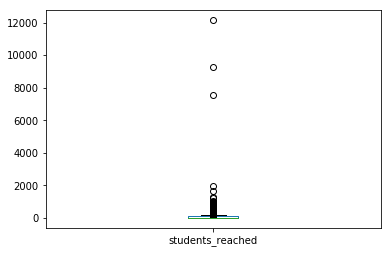

In [13]:
data['students_reached'].plot.box()

In [14]:
data['eligible_double_your_impact_match'].value_counts()

f    87887
t    37089
Name: eligible_double_your_impact_match, dtype: int64

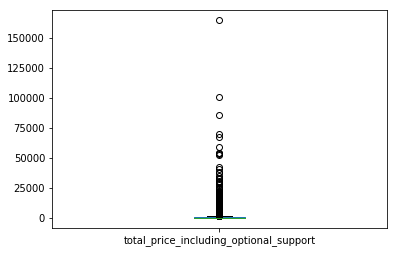

In [15]:
pipe.boxplot(data, 'total_price_including_optional_support')

Define the columns that we will convert to dummy variables, convert to binary, and discretize

In [14]:
interested_cols = [ 'school_metro', 'school_charter',
       'school_magnet', 'primary_focus_area', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded','over_60_days']
to_dummies = ['school_metro', 'primary_focus_area', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level']
to_discretize = ['total_price_including_optional_support', 'students_reached']
convert_to_binary = ['school_charter', 'school_magnet', 'eligible_double_your_impact_match']
data_select = data[interested_cols]
data_select.columns

Index(['school_metro', 'school_charter', 'school_magnet', 'primary_focus_area',
       'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded',
       'over_60_days'],
      dtype='object')

## Part 3. Create Machine Learning Models and Pre-process data in each Training and Testing set

First split the training data and testing data using the temporal holdouts, then complete the data conversion and pre-processing parts of each training set and testing set

In [28]:
test_1 = pipe.slice_time_data(data_select, 'date_posted','2012-07-01', '2012-10-31')
test_1 = test_1.drop(['date_posted', 'datefullyfunded'], axis=1)
test_2 = pipe.slice_time_data(data_select, 'date_posted','2013-01-01', '2013-04-30')
test_2 = test_2.drop(['date_posted', 'datefullyfunded'], axis=1)
test_3 = pipe.slice_time_data(data_select, 'date_posted','2013-07-01', '2013-10-31')
test_3 = test_3.drop(['date_posted', 'datefullyfunded'], axis=1)
train_1 = pipe.slice_time_data(data_select, 'date_posted','2012-01-01', '2012-04-30')
train_1 = train_1.drop(['date_posted', 'datefullyfunded'], axis=1)
train_2 = pipe.slice_time_data(data_select, 'date_posted','2012-01-01', '2012-10-31')
train_2 = train_2.drop(['date_posted', 'datefullyfunded'], axis=1)
train_3 = pipe.slice_time_data(data_select, 'date_posted','2012-01-01', '2013-04-30')
train_3 = train_3.drop(['date_posted', 'datefullyfunded'], axis=1)

In [29]:
test_1 = pipe.to_dummy(test_1, to_dummies)
test_2 = pipe.to_dummy(test_2, to_dummies)
test_3 = pipe.to_dummy(test_3, to_dummies)
train_1 = pipe.to_dummy(train_1, to_dummies)
train_2 = pipe.to_dummy(train_2, to_dummies)
train_3 = pipe.to_dummy(train_3, to_dummies)
for col in convert_to_binary:
    test_1[col] = test_1[col].apply(lambda x: pipe.cat_to_dummy(x, "t"))
    test_2[col] = test_2[col].apply(lambda x: pipe.cat_to_dummy(x, "t"))
    test_3[col] = test_3[col].apply(lambda x: pipe.cat_to_dummy(x, "t"))
    train_1[col] = train_1[col].apply(lambda x: pipe.cat_to_dummy(x, "t"))
    train_2[col] = train_2[col].apply(lambda x: pipe.cat_to_dummy(x, "t"))
    train_3[col] = train_3[col].apply(lambda x: pipe.cat_to_dummy(x, "t"))
pipe.fill_na(test_1, to_discretize)
pipe.fill_na(test_2, to_discretize)
pipe.fill_na(test_3, to_discretize)
pipe.fill_na(train_1, to_discretize)
pipe.fill_na(train_2, to_discretize)
pipe.fill_na(train_3, to_discretize)
pipe.discretize_col(test_1, to_discretize)
pipe.discretize_col(test_2, to_discretize)
pipe.discretize_col(test_3, to_discretize)
pipe.discretize_col(train_1, to_discretize)
pipe.discretize_col(train_2, to_discretize)
pipe.discretize_col(train_3, to_discretize)

In [30]:
features = ['school_charter', 'school_magnet',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match',
       'school_metro_rural', 'school_metro_suburban', 'school_metro_urban',
       'primary_focus_area_Applied Learning',
       'primary_focus_area_Health & Sports',
       'primary_focus_area_History & Civics',
       'primary_focus_area_Literacy & Language',
       'primary_focus_area_Math & Science',
       'primary_focus_area_Music & The Arts',
       'primary_focus_area_Special Needs',
       'secondary_focus_area_Applied Learning',
       'secondary_focus_area_Health & Sports',
       'secondary_focus_area_History & Civics',
       'secondary_focus_area_Literacy & Language',
       'secondary_focus_area_Math & Science',
       'secondary_focus_area_Music & The Arts',
       'secondary_focus_area_Special Needs', 'resource_type_Books',
       'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors', 'poverty_level_high poverty',
       'poverty_level_highest poverty', 'poverty_level_low poverty',
       'poverty_level_moderate poverty', 'grade_level_Grades 3-5',
       'grade_level_Grades 6-8', 'grade_level_Grades 9-12',
       'grade_level_Grades PreK-2']
label = ['over_60_days']
X_train_1 = train_1[features].values
y_train_1 = train_1[label[0]].values
X_test_1 = test_1[features].values
y_test_1 = test_1[label[0]].values
X_train_2 = train_2[features].values
y_train_2 = train_2[label[0]].values
X_test_2 = test_2[features].values
y_test_2 = test_2[label[0]].values
X_train_3 = train_3[features].values
y_train_3 = train_3[label[0]].values
X_test_3 = test_3[features].values
y_test_3 = test_3[label[0]].values

Call the models from the pipeline

In [37]:
clfs, grid= pipe.define_clfs_params()

In [38]:
models_to_run = []
for key, val in clfs.items():
    models_to_run.append(key)
models_to_run

['BG', 'RF', 'LR', 'SVM', 'GB', 'DT', 'KNN', 'NB']

In [39]:
grid

{'BG': {'n_estimators': [10, 100]},
 'RF': {'n_estimators': [1, 10, 100],
  'max_depth': [1, 5, 10, 20],
  'max_features': ['sqrt', 'log2']},
 'LR': {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]},
 'GB': {'n_estimators': [1, 10, 100], 'max_features': [3, 5, 10]},
 'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1, 5, 10]},
 'SVM': {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1]},
 'KNN': {'n_neighbors': [1, 5, 25], 'weights': ['uniform', 'distance']},
 'NB': {}}

In [40]:
clfs

{'BG': BaggingClassifier(base_estimator=None, bootstrap=True,
          bootstrap_features=False, max_features=1.0, max_samples=1.0,
          n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
          verbose=0, warm_start=False),
 'RF': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'LR': LogisticRegression(C=100000.0, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False),
 'SVM': LinearSVC(C=1.0, class_weig

## Part 4. Run Models

Fit and evaluate the models of the first testing dataset (training data: first half of 2012; testing data: second half of 2012)

BG


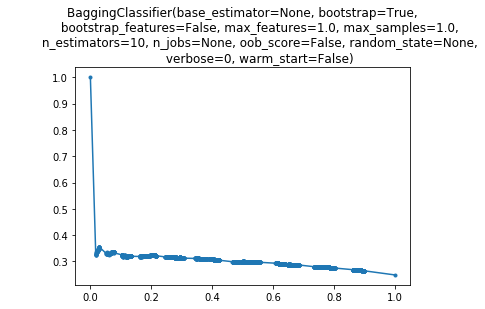

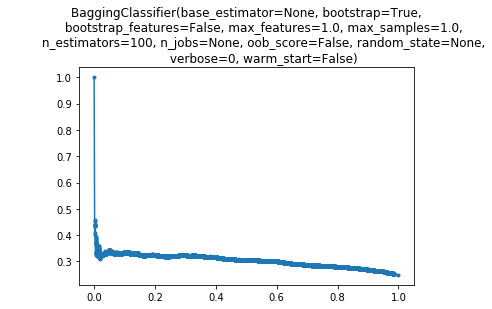

RF


C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


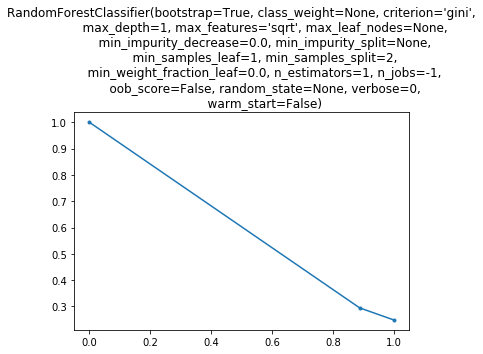

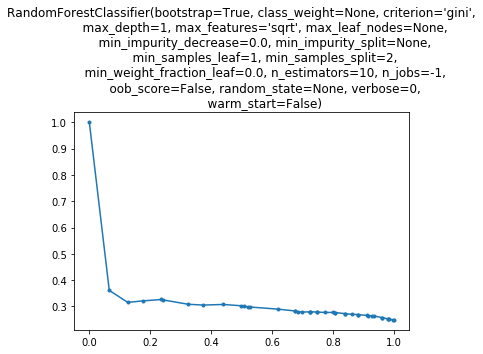

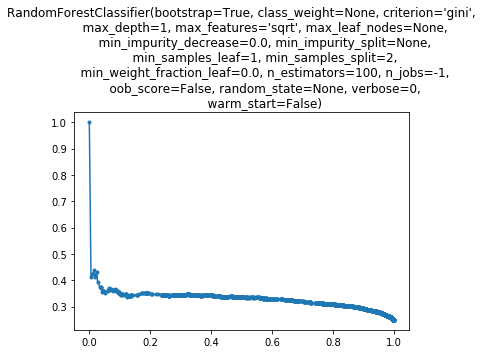

C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


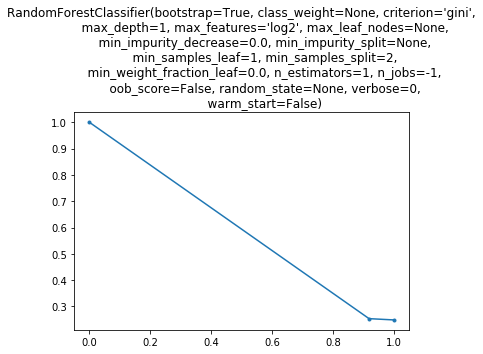

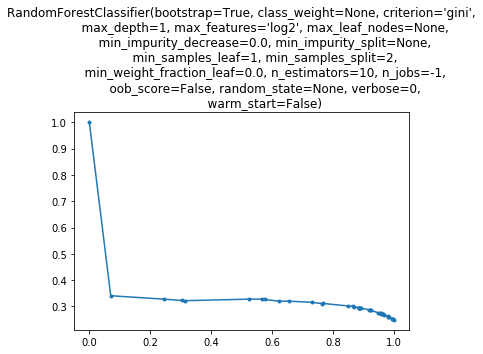

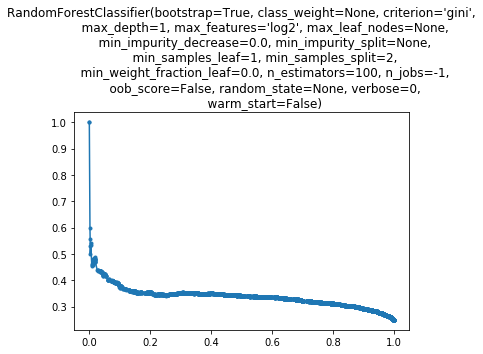

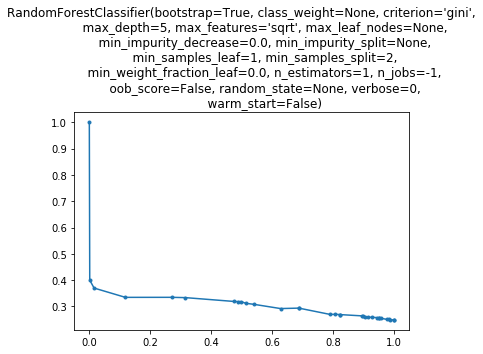

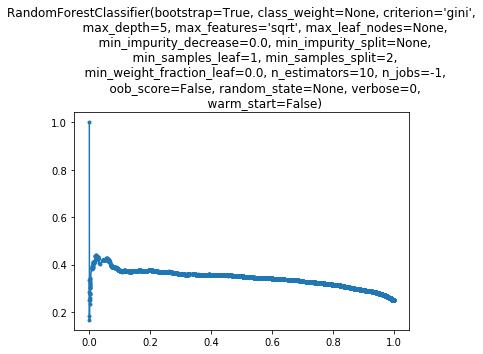

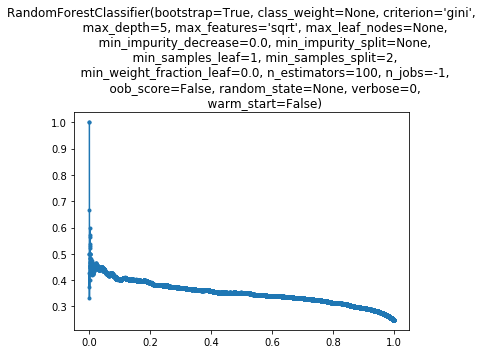

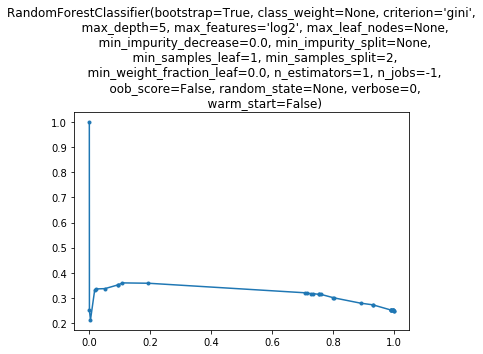

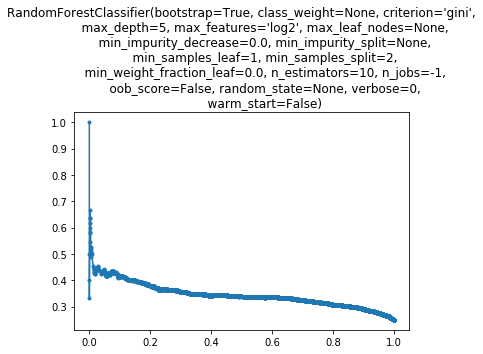

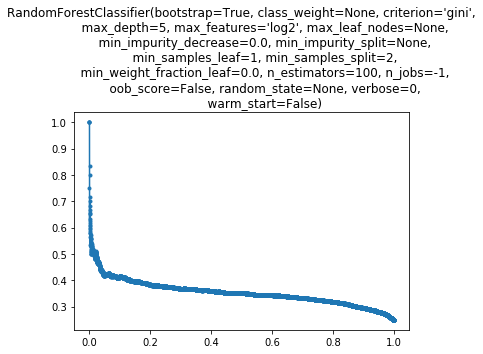

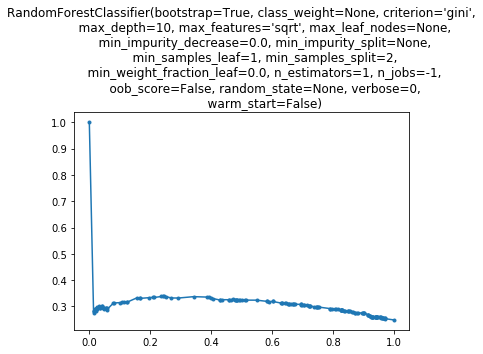

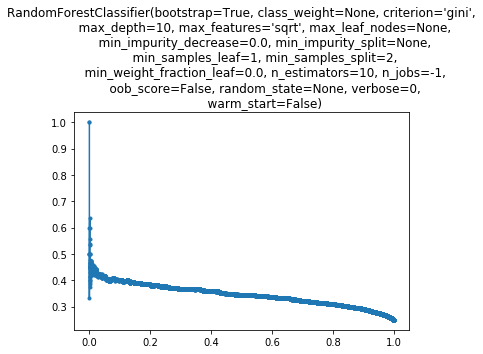

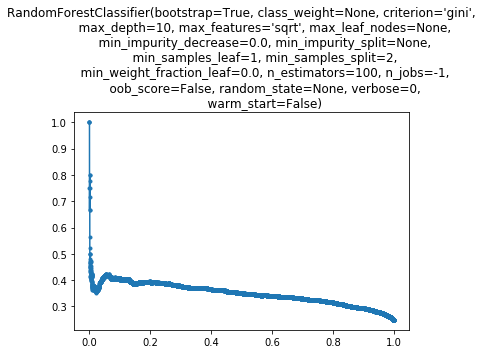

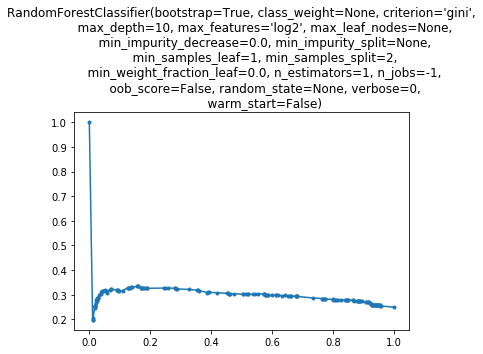

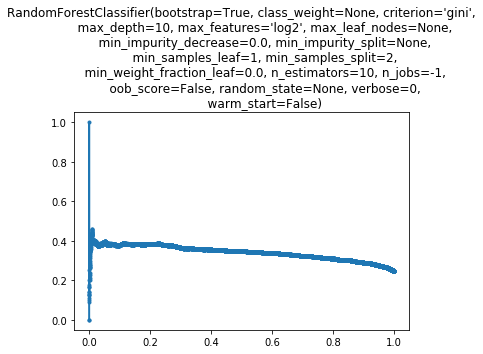

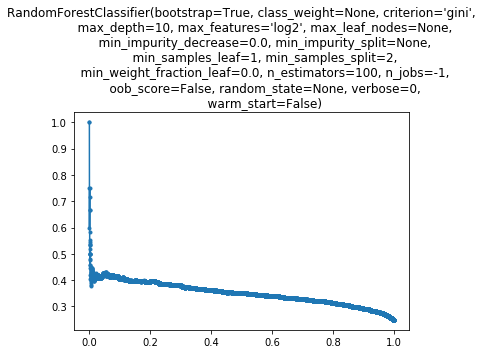

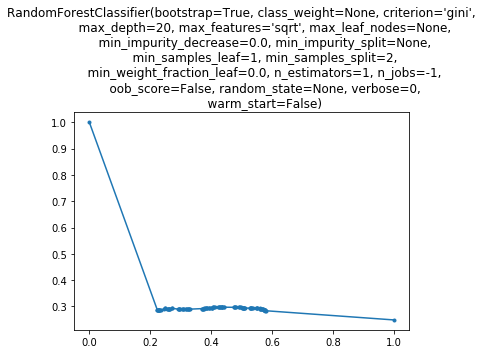

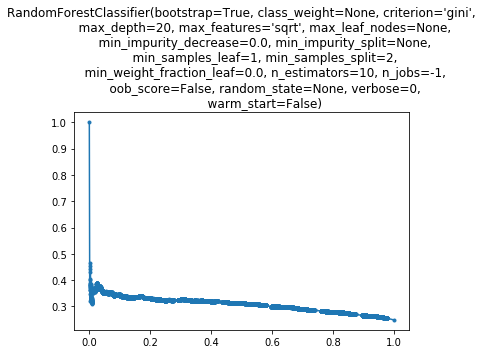

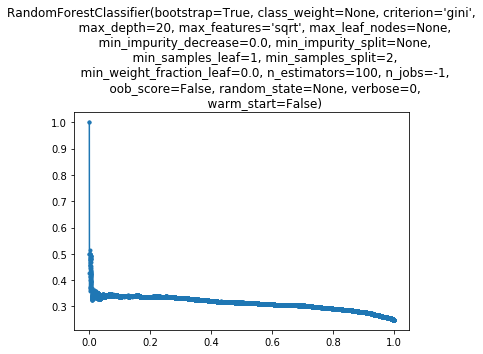

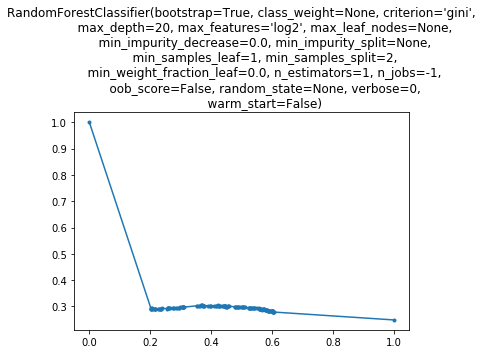

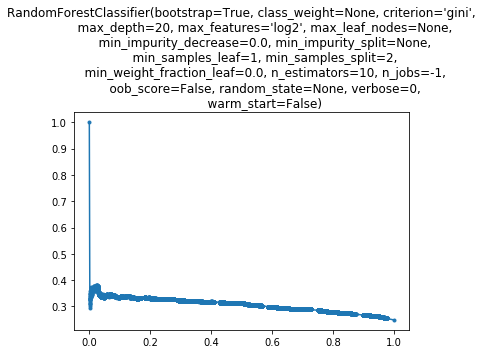

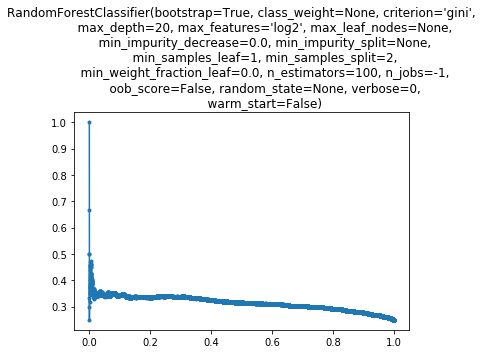

LR


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


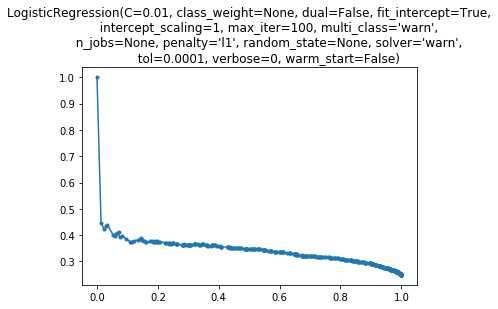

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


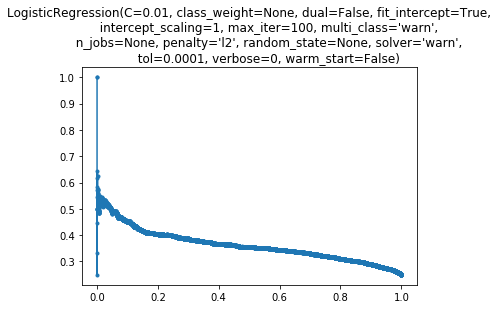

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


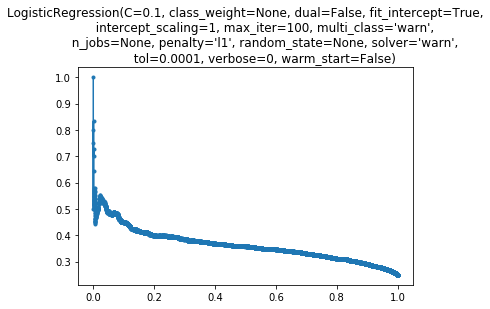

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


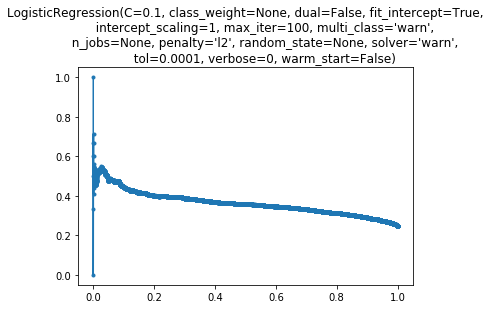

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


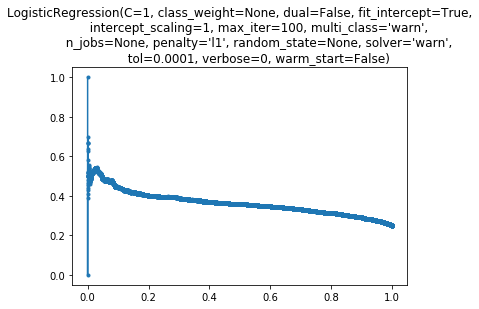

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


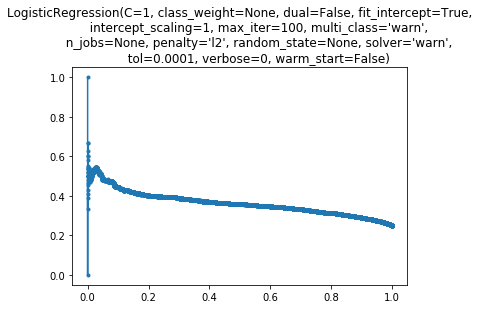

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


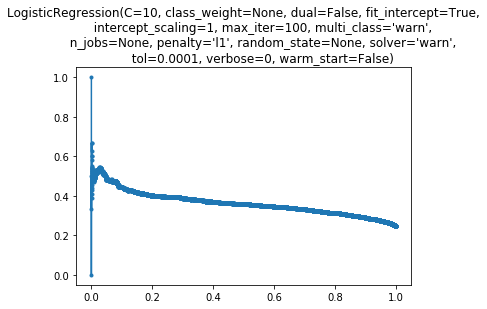

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


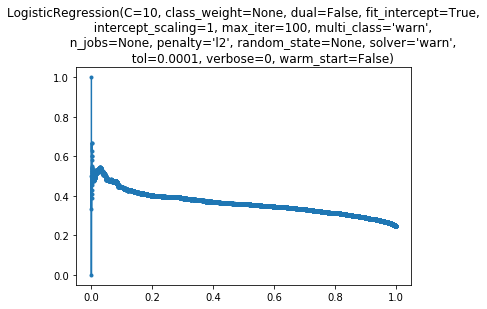

SVM


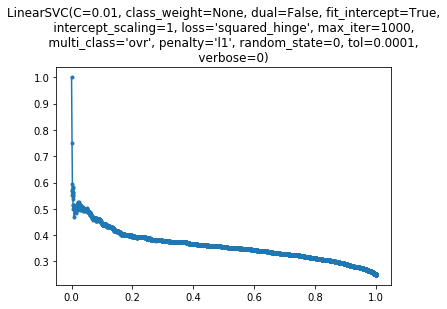

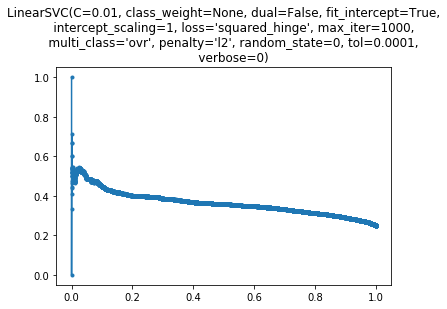

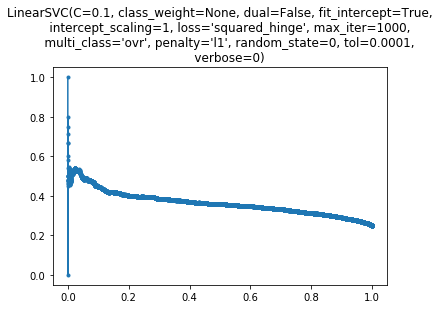

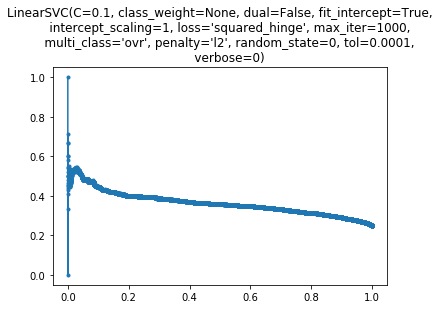

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


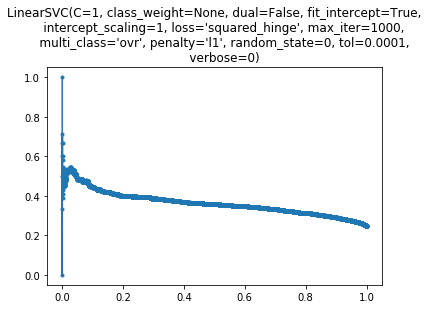

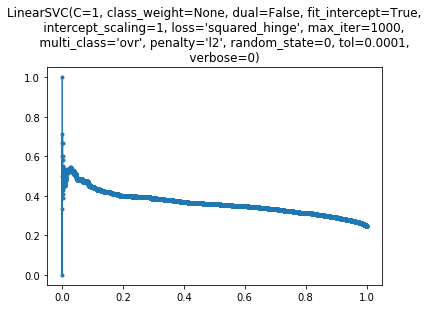

GB


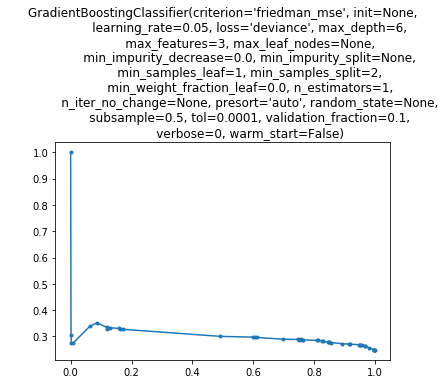

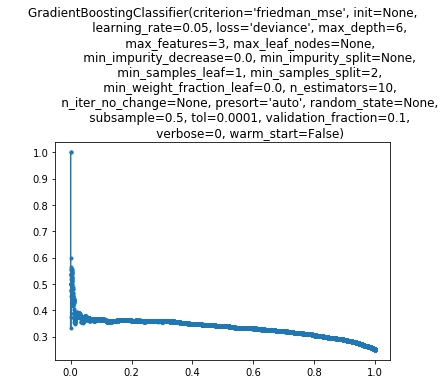

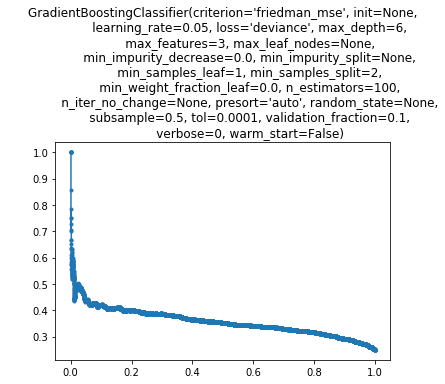

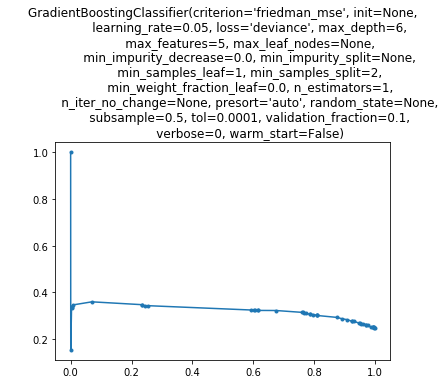

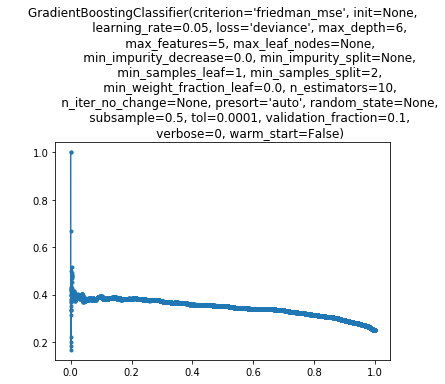

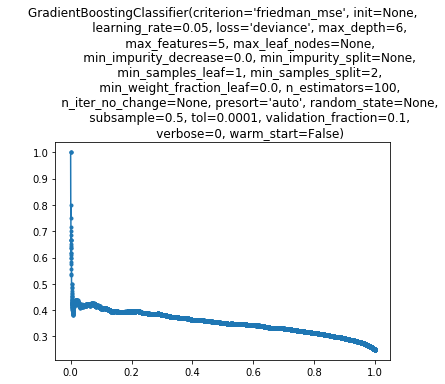

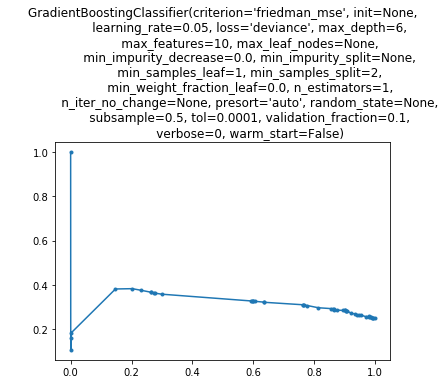

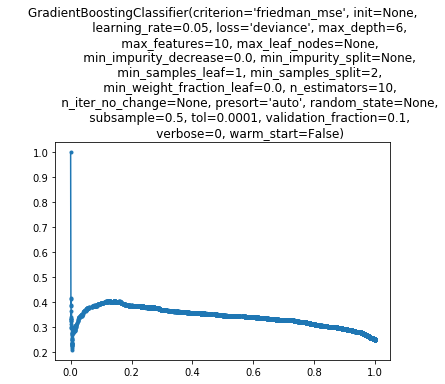

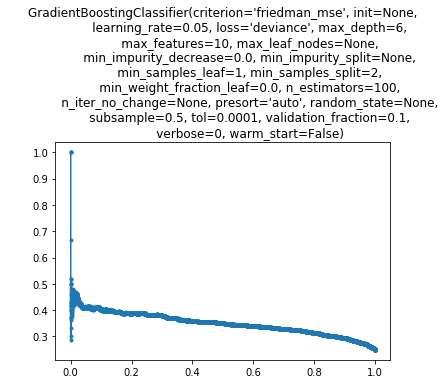

DT


C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


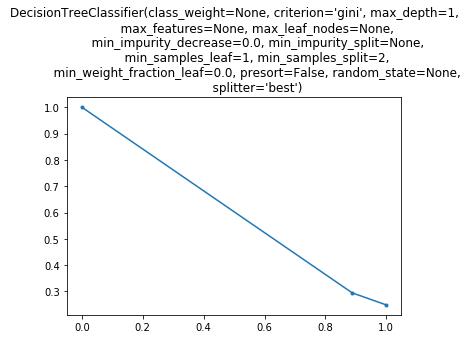

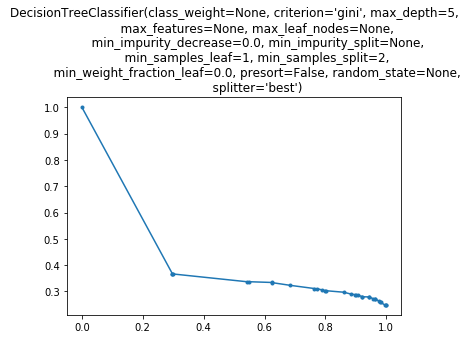

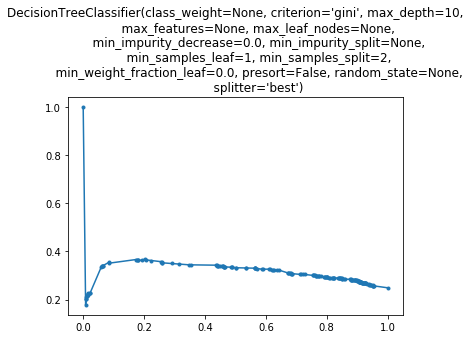

C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


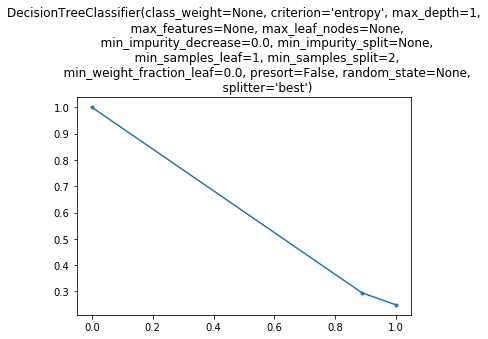

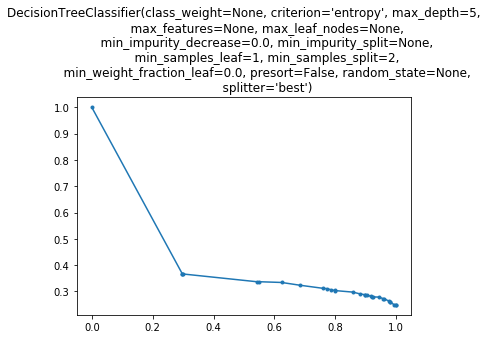

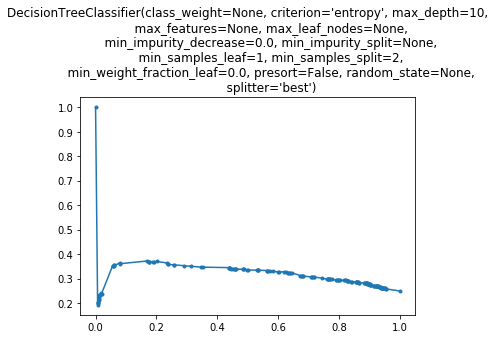

KNN


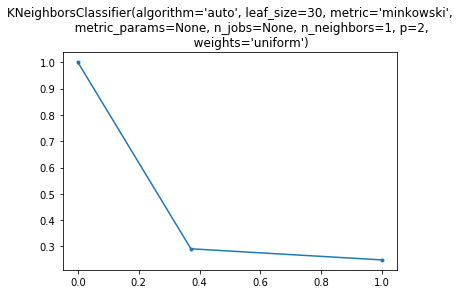

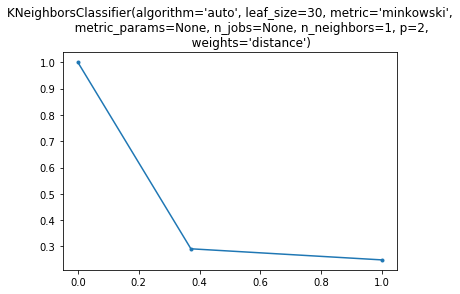

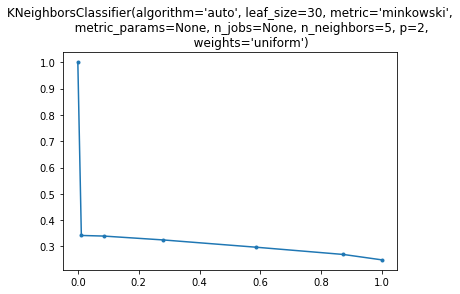

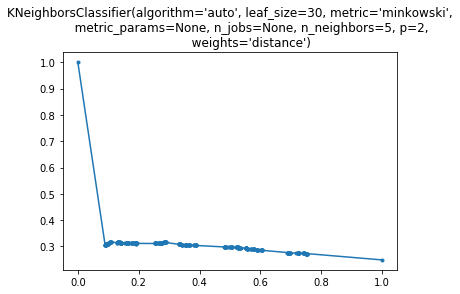

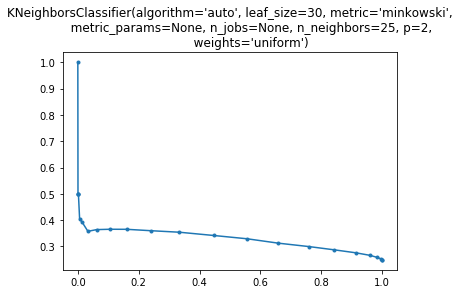

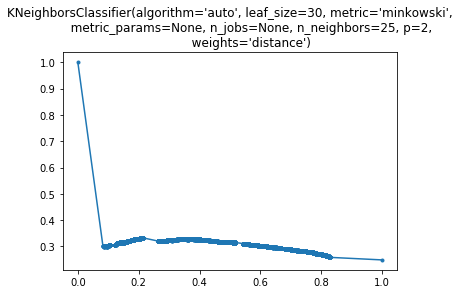

NB


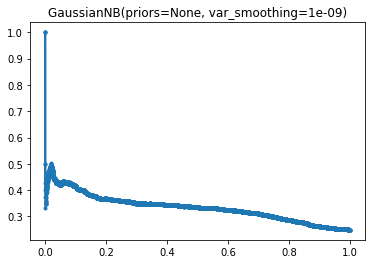

In [41]:
result1 = pipe.clf_loop(models_to_run, clfs, grid, X_train_1, X_test_1, y_train_1, y_test_1)

In [42]:
result1.sort_values(by='auc-roc', ascending=False)

model_type                                                clf  \
39        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
38        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
37        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
35        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
36        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
32         LR  LogisticRegression(C=10, class_weight=None, du...   
31         LR  LogisticRegression(C=10, class_weight=None, du...   
33         LR  LogisticRegression(C=10, class_weight=None, du...   
30         LR  LogisticRegression(C=10, class_weight=None, du...   
29         LR  LogisticRegression(C=10, class_weight=None, du...   
28         LR  LogisticRegression(C=10, class_weight=None, du...   
13         RF  (DecisionTreeClassifier(class_weight=None, cri...   
27         LR  LogisticRegression(C=10, class_weight=None, du...   
42         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
34        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
45         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
10         RF  (DecisionTreeClassifier(class_weight=None, cri...   
16         RF  (DecisionTreeClassifier(class_weight=None, cri...   
19         RF  (DecisionTreeClassifier(class_weight=None, cri...   
48         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
44         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
9          RF  (DecisionTreeClassifier(class_weight=None, cri...   
47         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
18         RF  (DecisionTreeClassifier(class_weight=None, cri...   
15         RF  (DecisionTreeClassifier(class_weight=None, cri...   
26         LR  LogisticRegression(C=10, class_weight=None, du...   
12         RF  (DecisionTreeClassifier(class_weight=None, cri...   
7          RF  (DecisionTreeClassifier(class_weight=None, cri...   
53         DT  DecisionTreeClassifier(class_weight=None, crit...   
50         DT  DecisionTreeClassifier(class_weight=None, crit...   
..        ...                                                ...   
46         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
6          RF  (DecisionTreeClassifier(class_weight=None, cri...   
43         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
59        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
54         DT  DecisionTreeClassifier(class_weight=None, crit...   
11         RF  (DecisionTreeClassifier(class_weight=None, cri...   
51         DT  DecisionTreeClassifier(class_weight=None, crit...   
61         NB       GaussianNB(priors=None, var_smoothing=1e-09)   
14         RF  (DecisionTreeClassifier(class_weight=None, cri...   
25         RF  (DecisionTreeClassifier(class_weight=None, cri...   
22         RF  (DecisionTreeClassifier(class_weight=None, cri...   
21         RF  (DecisionTreeClassifier(class_weight=None, cri...   
24         RF  (DecisionTreeClassifier(class_weight=None, cri...   
2          RF  (DecisionTreeClassifier(class_weight=None, cri...   
52         DT  DecisionTreeClassifier(class_weight=None, crit...   
49         DT  DecisionTreeClassifier(class_weight=None, crit...   
40         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
1          BG  (DecisionTreeClassifier(class_weight=None, cri...   
17         RF  (DecisionTreeClassifier(class_weight=None, cri...   
8          RF  (DecisionTreeClassifier(class_weight=None, cri...   
57        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
60        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
3          RF  (DecisionTreeClassifier(class_weight=None, cri...   
0          BG  (DecisionTreeClassifier(class_weight=None, cri...   
58        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
23         RF  (DecisionTreeClassifier(class_weight=None, cri...   
20         RF  (DecisionTreeClassifier(class_weight=None, c

In [43]:
result1.sort_values(by='p_at_5', ascending=False)

model_type                                                clf  \
27         LR  LogisticRegression(C=10, class_weight=None, du...   
35        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
34        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
28         LR  LogisticRegression(C=10, class_weight=None, du...   
39        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
37        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
29         LR  LogisticRegression(C=10, class_weight=None, du...   
38        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
36        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
31         LR  LogisticRegression(C=10, class_weight=None, du...   
33         LR  LogisticRegression(C=10, class_weight=None, du...   
32         LR  LogisticRegression(C=10, class_weight=None, du...   
30         LR  LogisticRegression(C=10, class_weight=None, du...   
12         RF  (DecisionTreeClassifier(class_weight=None, cri...   
61         NB       GaussianNB(priors=None, var_smoothing=1e-09)   
42         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
45         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
13         RF  (DecisionTreeClassifier(class_weight=None, cri...   
19         RF  (DecisionTreeClassifier(class_weight=None, cri...   
10         RF  (DecisionTreeClassifier(class_weight=None, cri...   
48         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
16         RF  (DecisionTreeClassifier(class_weight=None, cri...   
15         RF  (DecisionTreeClassifier(class_weight=None, cri...   
7          RF  (DecisionTreeClassifier(class_weight=None, cri...   
47         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
18         RF  (DecisionTreeClassifier(class_weight=None, cri...   
9          RF  (DecisionTreeClassifier(class_weight=None, cri...   
26         LR  LogisticRegression(C=10, class_weight=None, du...   
44         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
41         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
..        ...                                                ...   
43         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
24         RF  (DecisionTreeClassifier(class_weight=None, cri...   
25         RF  (DecisionTreeClassifier(class_weight=None, cri...   
22         RF  (DecisionTreeClassifier(class_weight=None, cri...   
0          BG  (DecisionTreeClassifier(class_weight=None, cri...   
1          BG  (DecisionTreeClassifier(class_weight=None, cri...   
3          RF  (DecisionTreeClassifier(class_weight=None, cri...   
57        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
6          RF  (DecisionTreeClassifier(class_weight=None, cri...   
51         DT  DecisionTreeClassifier(class_weight=None, crit...   
54         DT  DecisionTreeClassifier(class_weight=None, crit...   
60        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
40         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
59        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
17         RF  (DecisionTreeClassifier(class_weight=None, cri...   
14         RF  (DecisionTreeClassifier(class_weight=None, cri...   
58        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
11         RF  (DecisionTreeClassifier(class_weight=None, cri...   
8          RF  (DecisionTreeClassifier(class_weight=None, cri...   
46         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
23         RF  (DecisionTreeClassifier(class_weight=None, cri...   
50         DT  DecisionTreeClassifier(class_weight=None, crit...   
53         DT  DecisionTreeClassifier(class_weight=None, crit...   
55        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
56        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
20         RF  (DecisionTreeClassifier(class_weight=None, cri...   
5          RF  (DecisionTreeClassifier(class_weight=None, c

In [44]:
result1.sort_values(by='f1_at_5', ascending=False)

model_type                                                clf  \
27         LR  LogisticRegression(C=10, class_weight=None, du...   
35        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
34        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
28         LR  LogisticRegression(C=10, class_weight=None, du...   
39        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
37        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
29         LR  LogisticRegression(C=10, class_weight=None, du...   
38        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
36        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
31         LR  LogisticRegression(C=10, class_weight=None, du...   
33         LR  LogisticRegression(C=10, class_weight=None, du...   
32         LR  LogisticRegression(C=10, class_weight=None, du...   
30         LR  LogisticRegression(C=10, class_weight=None, du...   
12         RF  (DecisionTreeClassifier(class_weight=None, cri...   
61         NB       GaussianNB(priors=None, var_smoothing=1e-09)   
42         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
45         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
13         RF  (DecisionTreeClassifier(class_weight=None, cri...   
19         RF  (DecisionTreeClassifier(class_weight=None, cri...   
10         RF  (DecisionTreeClassifier(class_weight=None, cri...   
48         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
16         RF  (DecisionTreeClassifier(class_weight=None, cri...   
15         RF  (DecisionTreeClassifier(class_weight=None, cri...   
7          RF  (DecisionTreeClassifier(class_weight=None, cri...   
47         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
9          RF  (DecisionTreeClassifier(class_weight=None, cri...   
18         RF  (DecisionTreeClassifier(class_weight=None, cri...   
26         LR  LogisticRegression(C=10, class_weight=None, du...   
44         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
41         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
..        ...                                                ...   
43         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
25         RF  (DecisionTreeClassifier(class_weight=None, cri...   
24         RF  (DecisionTreeClassifier(class_weight=None, cri...   
22         RF  (DecisionTreeClassifier(class_weight=None, cri...   
0          BG  (DecisionTreeClassifier(class_weight=None, cri...   
1          BG  (DecisionTreeClassifier(class_weight=None, cri...   
3          RF  (DecisionTreeClassifier(class_weight=None, cri...   
57        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
6          RF  (DecisionTreeClassifier(class_weight=None, cri...   
51         DT  DecisionTreeClassifier(class_weight=None, crit...   
54         DT  DecisionTreeClassifier(class_weight=None, crit...   
60        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
40         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
59        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
17         RF  (DecisionTreeClassifier(class_weight=None, cri...   
14         RF  (DecisionTreeClassifier(class_weight=None, cri...   
58        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
11         RF  (DecisionTreeClassifier(class_weight=None, cri...   
8          RF  (DecisionTreeClassifier(class_weight=None, cri...   
46         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
20         RF  (DecisionTreeClassifier(class_weight=None, cri...   
23         RF  (DecisionTreeClassifier(class_weight=None, cri...   
53         DT  DecisionTreeClassifier(class_weight=None, crit...   
55        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
56        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
50         DT  DecisionTreeClassifier(class_weight=None, crit...   
2          RF  (DecisionTreeClassifier(class_weight=None, c

Fit and evaluate the models of the second testing dataset (training data: data of full year 2012; testing data: first half of 2013)

BG


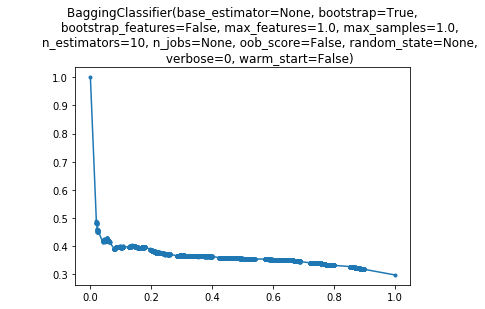

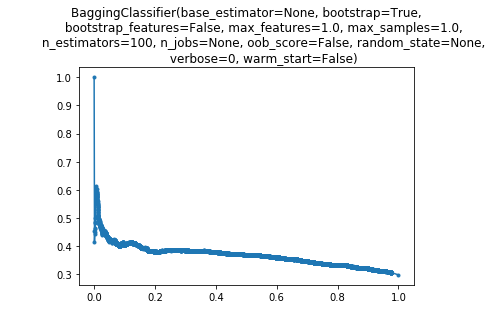

RF


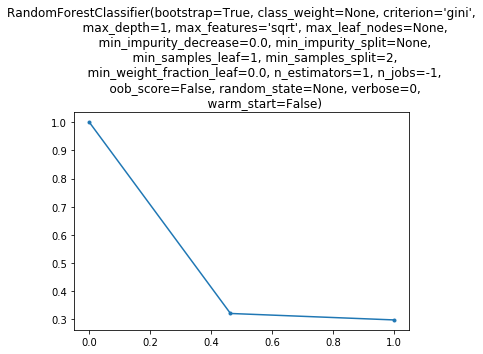

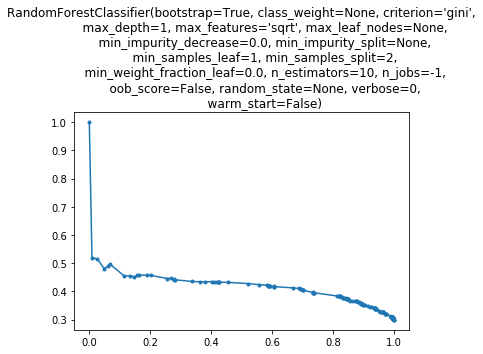

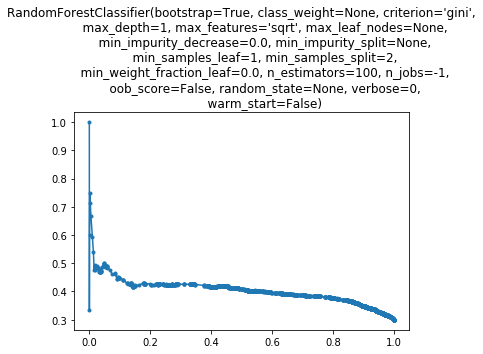

C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


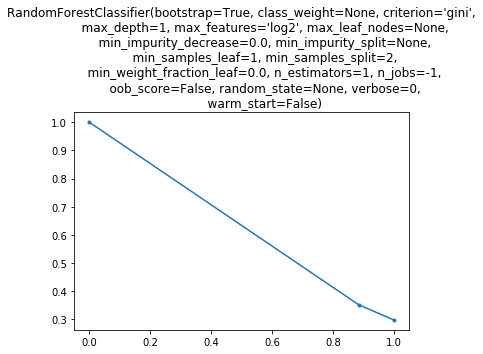

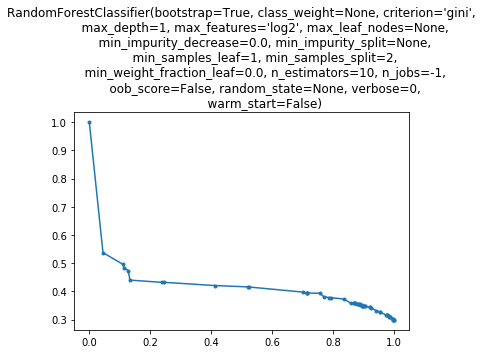

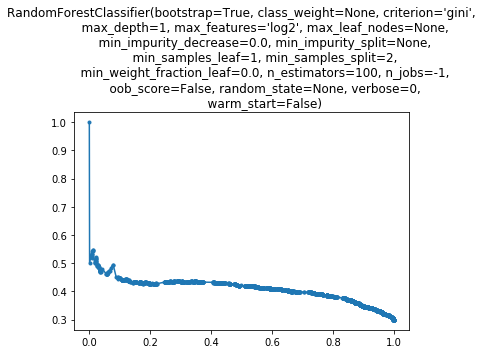

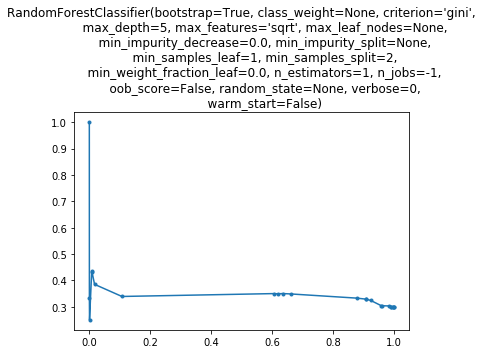

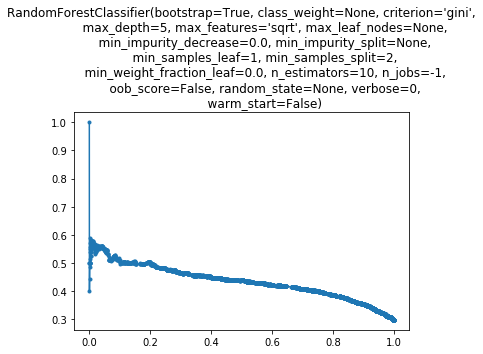

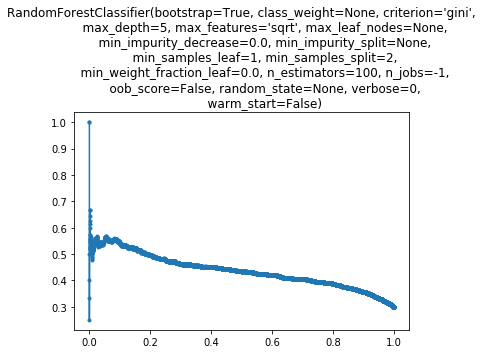

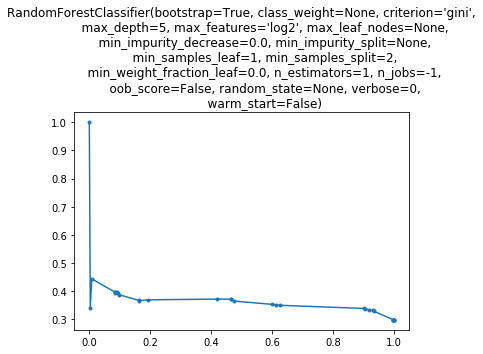

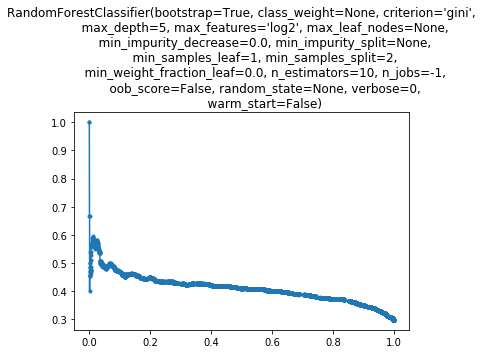

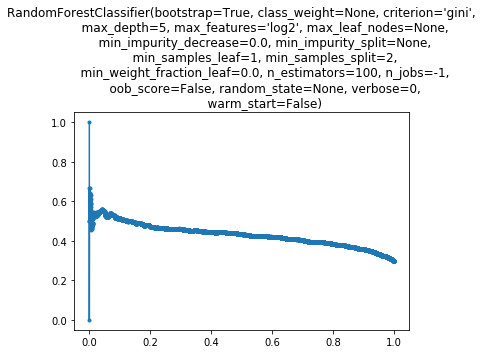

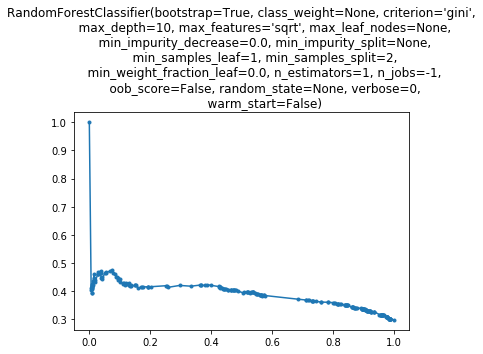

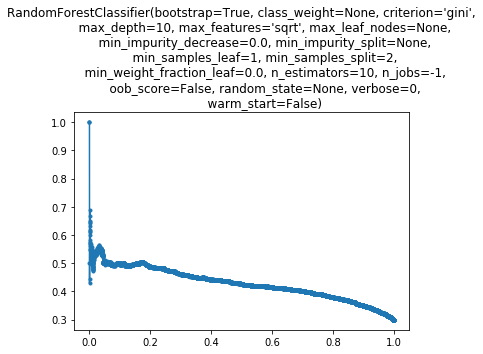

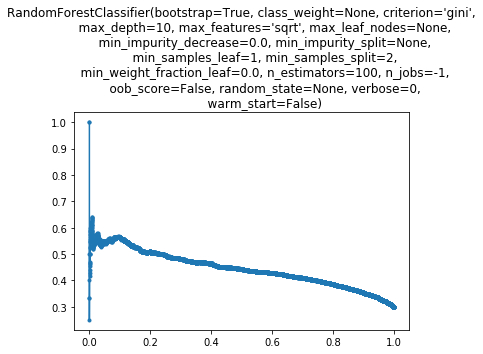

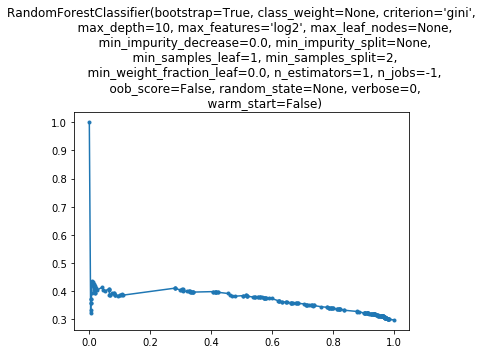

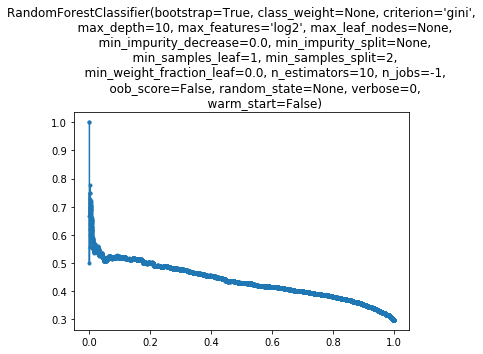

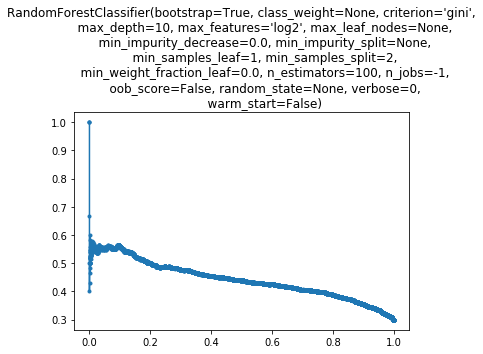

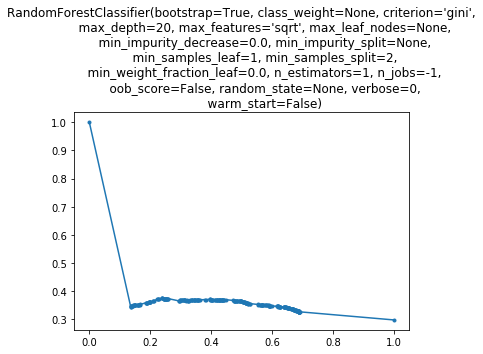

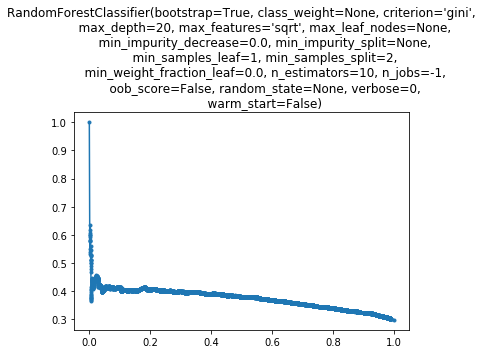

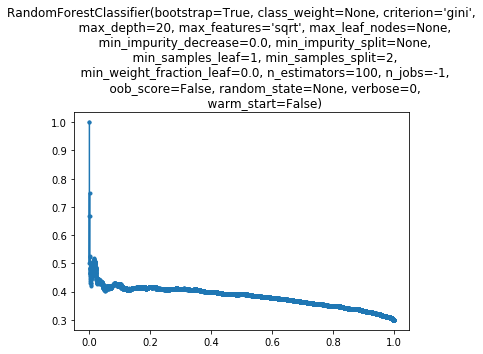

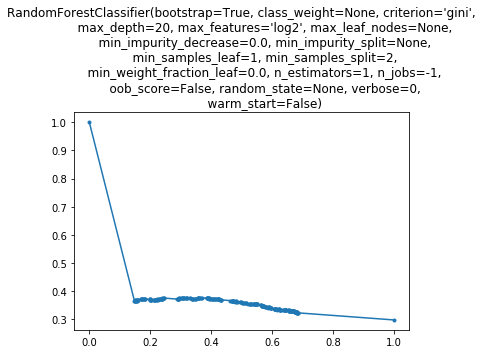

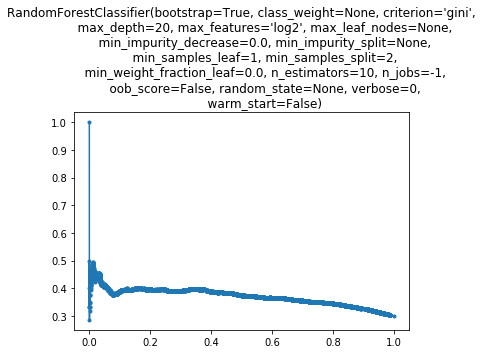

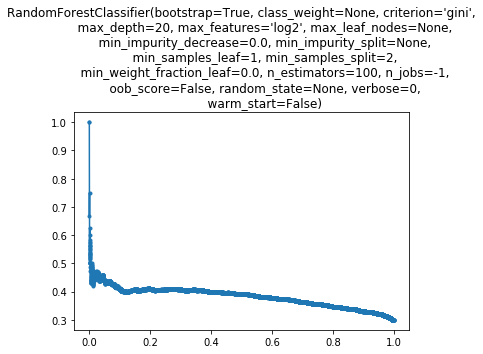

LR


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


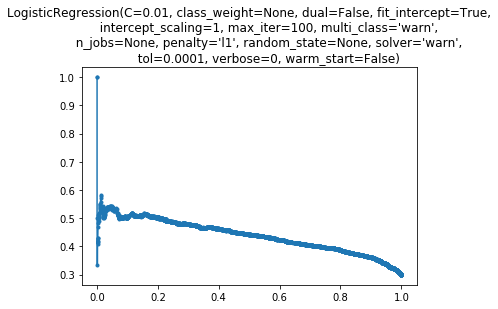

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


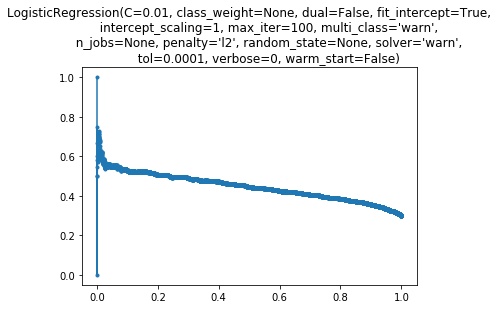

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


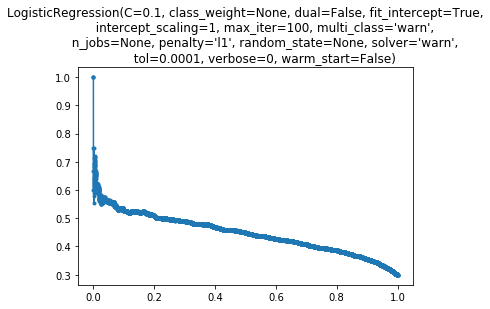

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


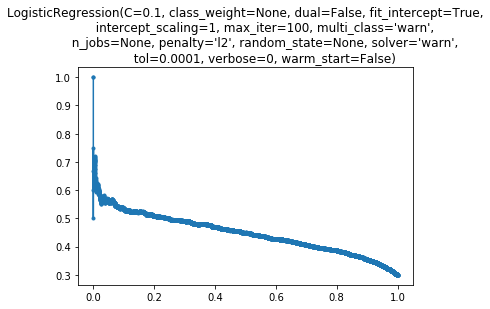

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


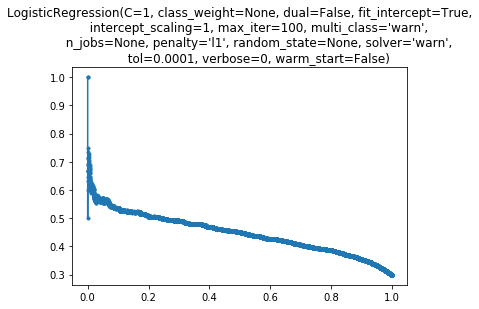

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


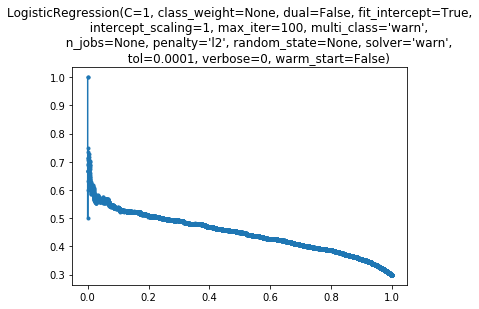

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


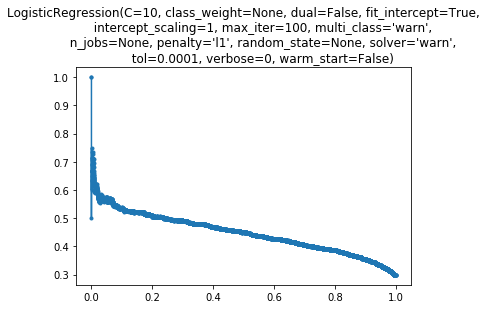

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


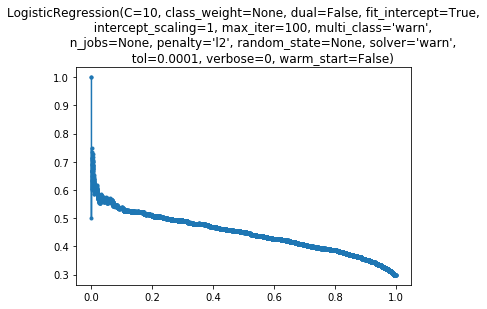

SVM


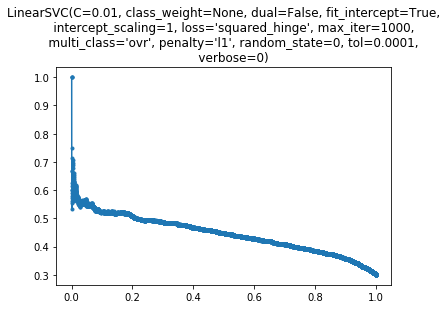

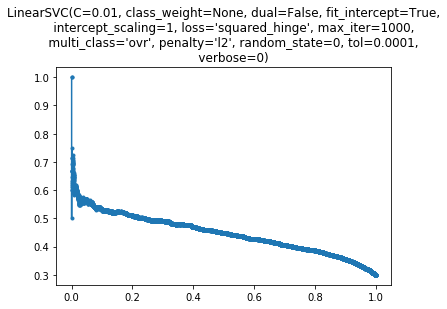

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


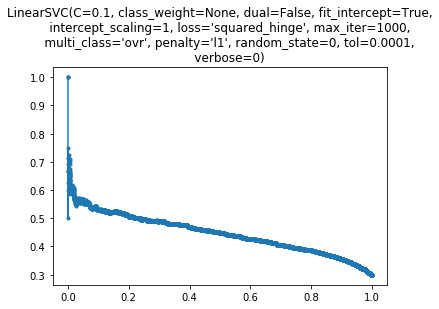

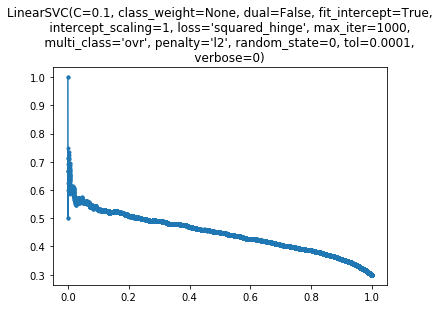

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


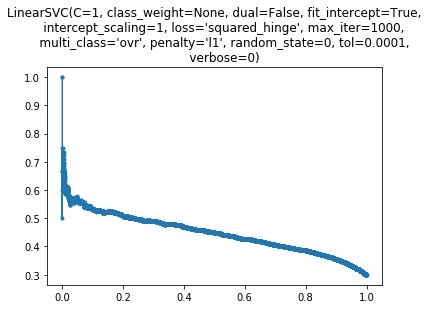

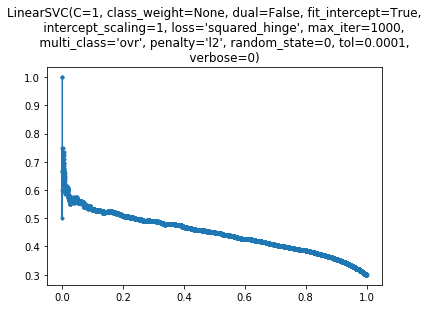

GB


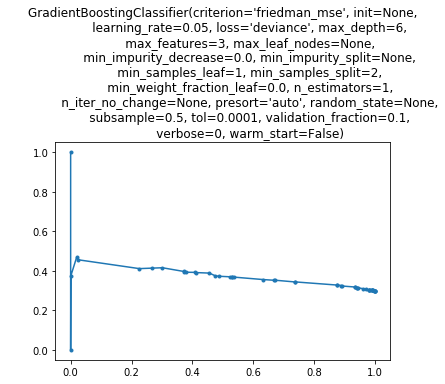

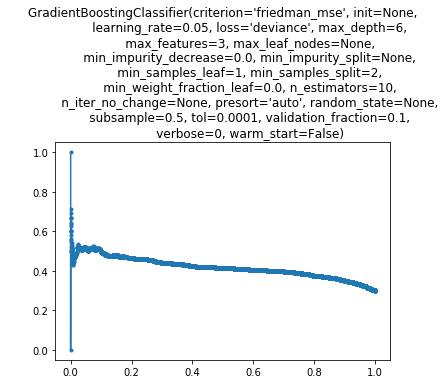

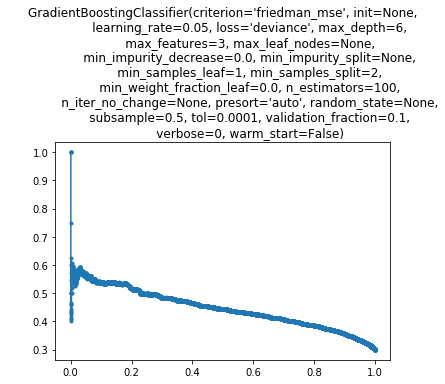

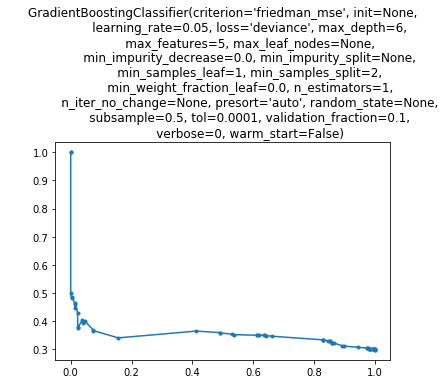

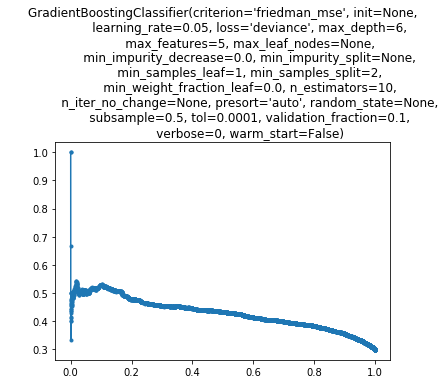

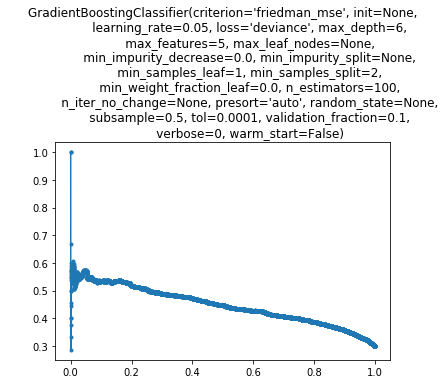

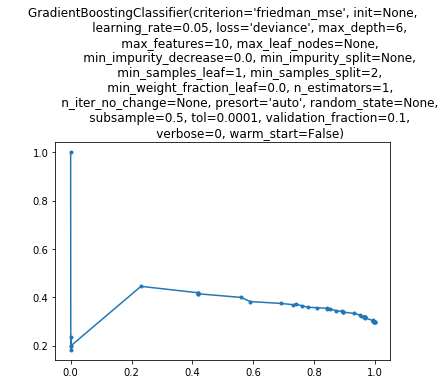

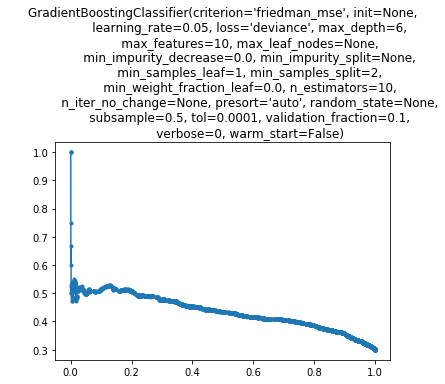

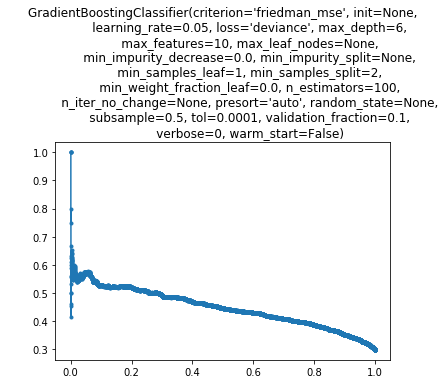

DT


C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


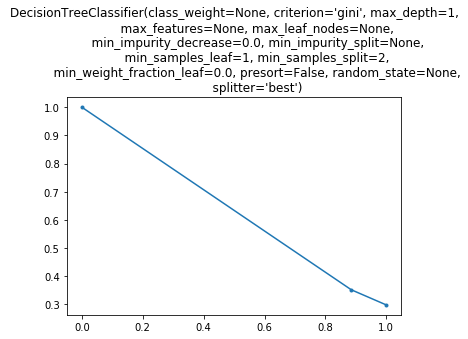

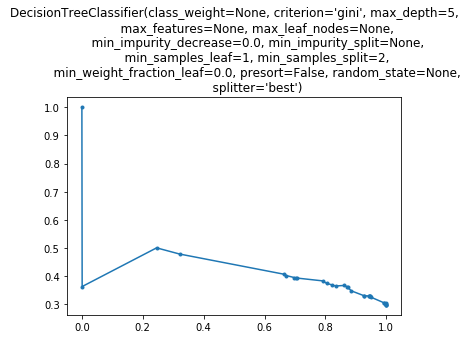

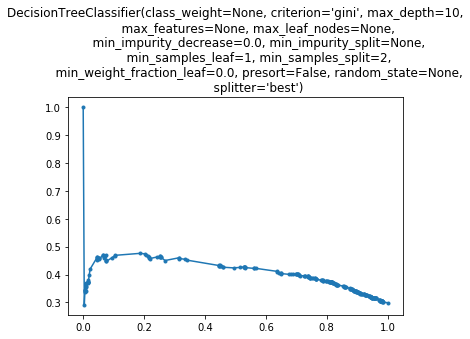

C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


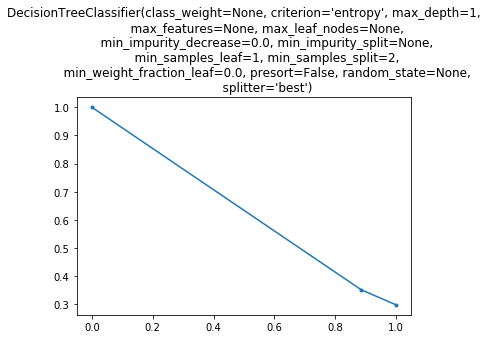

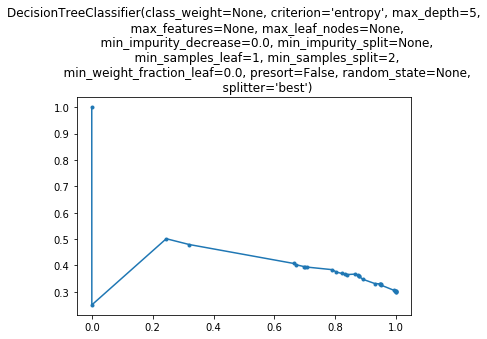

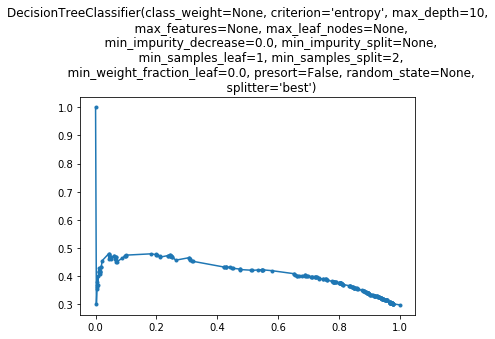

KNN


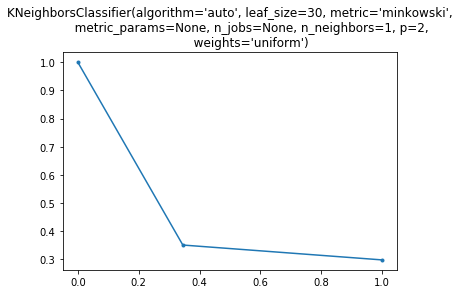

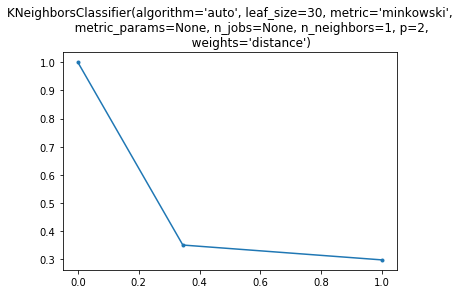

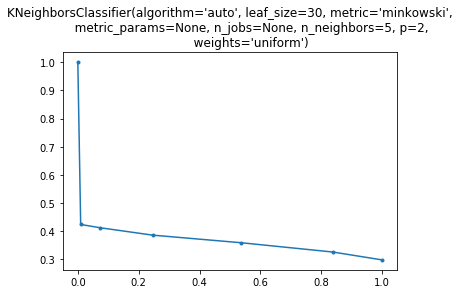

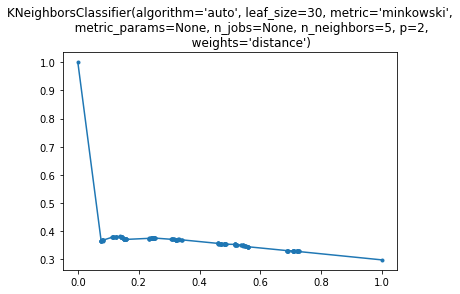

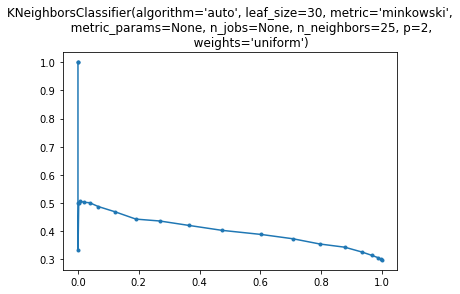

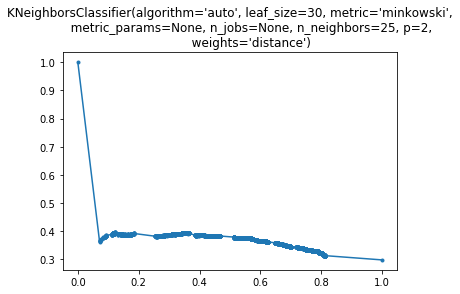

NB


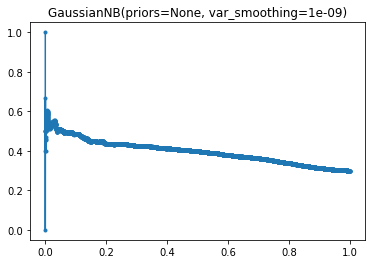

In [45]:
result2 = pipe.clf_loop(models_to_run, clfs, grid, X_train_2, X_test_2, y_train_2, y_test_2)

In [46]:
result2.sort_values(by='auc-roc', ascending=False)

model_type                                                clf  \
48         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
45         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
34        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
27         LR  LogisticRegression(C=10, class_weight=None, du...   
38        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
37        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
39        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
35        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
36        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
28         LR  LogisticRegression(C=10, class_weight=None, du...   
32         LR  LogisticRegression(C=10, class_weight=None, du...   
29         LR  LogisticRegression(C=10, class_weight=None, du...   
33         LR  LogisticRegression(C=10, class_weight=None, du...   
30         LR  LogisticRegression(C=10, class_weight=None, du...   
31         LR  LogisticRegression(C=10, class_weight=None, du...   
42         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
26         LR  LogisticRegression(C=10, class_weight=None, du...   
16         RF  (DecisionTreeClassifier(class_weight=None, cri...   
19         RF  (DecisionTreeClassifier(class_weight=None, cri...   
9          RF  (DecisionTreeClassifier(class_weight=None, cri...   
10         RF  (DecisionTreeClassifier(class_weight=None, cri...   
47         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
13         RF  (DecisionTreeClassifier(class_weight=None, cri...   
18         RF  (DecisionTreeClassifier(class_weight=None, cri...   
44         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
3          RF  (DecisionTreeClassifier(class_weight=None, cri...   
15         RF  (DecisionTreeClassifier(class_weight=None, cri...   
53         DT  DecisionTreeClassifier(class_weight=None, crit...   
50         DT  DecisionTreeClassifier(class_weight=None, crit...   
7          RF  (DecisionTreeClassifier(class_weight=None, cri...   
..        ...                                                ...   
54         DT  DecisionTreeClassifier(class_weight=None, crit...   
6          RF  (DecisionTreeClassifier(class_weight=None, cri...   
12         RF  (DecisionTreeClassifier(class_weight=None, cri...   
4          RF  (DecisionTreeClassifier(class_weight=None, cri...   
46         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
59        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
14         RF  (DecisionTreeClassifier(class_weight=None, cri...   
22         RF  (DecisionTreeClassifier(class_weight=None, cri...   
25         RF  (DecisionTreeClassifier(class_weight=None, cri...   
61         NB       GaussianNB(priors=None, var_smoothing=1e-09)   
17         RF  (DecisionTreeClassifier(class_weight=None, cri...   
21         RF  (DecisionTreeClassifier(class_weight=None, cri...   
24         RF  (DecisionTreeClassifier(class_weight=None, cri...   
40         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
11         RF  (DecisionTreeClassifier(class_weight=None, cri...   
1          BG  (DecisionTreeClassifier(class_weight=None, cri...   
5          RF  (DecisionTreeClassifier(class_weight=None, cri...   
52         DT  DecisionTreeClassifier(class_weight=None, crit...   
49         DT  DecisionTreeClassifier(class_weight=None, crit...   
60        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
0          BG  (DecisionTreeClassifier(class_weight=None, cri...   
57        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
43         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
8          RF  (DecisionTreeClassifier(class_weight=None, cri...   
58        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
20         RF  (DecisionTreeClassifier(class_weight=None, cri...   
23         RF  (DecisionTreeClassifier(class_weight=None, c

In [47]:
result2.sort_values(by='p_at_5', ascending=False)

model_type                                                clf  \
19         RF  (DecisionTreeClassifier(class_weight=None, cri...   
16         RF  (DecisionTreeClassifier(class_weight=None, cri...   
10         RF  (DecisionTreeClassifier(class_weight=None, cri...   
38        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
37        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
36        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
39        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
42         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
35        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
27         LR  LogisticRegression(C=10, class_weight=None, du...   
30         LR  LogisticRegression(C=10, class_weight=None, du...   
28         LR  LogisticRegression(C=10, class_weight=None, du...   
29         LR  LogisticRegression(C=10, class_weight=None, du...   
32         LR  LogisticRegression(C=10, class_weight=None, du...   
33         LR  LogisticRegression(C=10, class_weight=None, du...   
31         LR  LogisticRegression(C=10, class_weight=None, du...   
45         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
34        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
48         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
18         RF  (DecisionTreeClassifier(class_weight=None, cri...   
44         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
13         RF  (DecisionTreeClassifier(class_weight=None, cri...   
9          RF  (DecisionTreeClassifier(class_weight=None, cri...   
41         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
26         LR  LogisticRegression(C=10, class_weight=None, du...   
47         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
61         NB       GaussianNB(priors=None, var_smoothing=1e-09)   
15         RF  (DecisionTreeClassifier(class_weight=None, cri...   
12         RF  (DecisionTreeClassifier(class_weight=None, cri...   
7          RF  (DecisionTreeClassifier(class_weight=None, cri...   
..        ...                                                ...   
51         DT  DecisionTreeClassifier(class_weight=None, crit...   
25         RF  (DecisionTreeClassifier(class_weight=None, cri...   
54         DT  DecisionTreeClassifier(class_weight=None, crit...   
22         RF  (DecisionTreeClassifier(class_weight=None, cri...   
1          BG  (DecisionTreeClassifier(class_weight=None, cri...   
21         RF  (DecisionTreeClassifier(class_weight=None, cri...   
3          RF  (DecisionTreeClassifier(class_weight=None, cri...   
59        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
17         RF  (DecisionTreeClassifier(class_weight=None, cri...   
24         RF  (DecisionTreeClassifier(class_weight=None, cri...   
57        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
0          BG  (DecisionTreeClassifier(class_weight=None, cri...   
6          RF  (DecisionTreeClassifier(class_weight=None, cri...   
11         RF  (DecisionTreeClassifier(class_weight=None, cri...   
43         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
58        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
60        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
40         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
8          RF  (DecisionTreeClassifier(class_weight=None, cri...   
46         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
50         DT  DecisionTreeClassifier(class_weight=None, crit...   
53         DT  DecisionTreeClassifier(class_weight=None, crit...   
55        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
56        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
20         RF  (DecisionTreeClassifier(class_weight=None, cri...   
23         RF  (DecisionTreeClassifier(class_weight=None, cri...   
2          RF  (DecisionTreeClassifier(class_weight=None, c

In [48]:
result2.sort_values(by='f1_at_5', ascending=False)

model_type                                                clf  \
19         RF  (DecisionTreeClassifier(class_weight=None, cri...   
16         RF  (DecisionTreeClassifier(class_weight=None, cri...   
10         RF  (DecisionTreeClassifier(class_weight=None, cri...   
37        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
36        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
38        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
39        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
42         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
35        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
27         LR  LogisticRegression(C=10, class_weight=None, du...   
30         LR  LogisticRegression(C=10, class_weight=None, du...   
33         LR  LogisticRegression(C=10, class_weight=None, du...   
32         LR  LogisticRegression(C=10, class_weight=None, du...   
31         LR  LogisticRegression(C=10, class_weight=None, du...   
29         LR  LogisticRegression(C=10, class_weight=None, du...   
28         LR  LogisticRegression(C=10, class_weight=None, du...   
45         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
48         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
34        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
18         RF  (DecisionTreeClassifier(class_weight=None, cri...   
13         RF  (DecisionTreeClassifier(class_weight=None, cri...   
44         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
9          RF  (DecisionTreeClassifier(class_weight=None, cri...   
41         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
26         LR  LogisticRegression(C=10, class_weight=None, du...   
47         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
61         NB       GaussianNB(priors=None, var_smoothing=1e-09)   
15         RF  (DecisionTreeClassifier(class_weight=None, cri...   
12         RF  (DecisionTreeClassifier(class_weight=None, cri...   
7          RF  (DecisionTreeClassifier(class_weight=None, cri...   
..        ...                                                ...   
51         DT  DecisionTreeClassifier(class_weight=None, crit...   
25         RF  (DecisionTreeClassifier(class_weight=None, cri...   
54         DT  DecisionTreeClassifier(class_weight=None, crit...   
22         RF  (DecisionTreeClassifier(class_weight=None, cri...   
1          BG  (DecisionTreeClassifier(class_weight=None, cri...   
21         RF  (DecisionTreeClassifier(class_weight=None, cri...   
3          RF  (DecisionTreeClassifier(class_weight=None, cri...   
59        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
17         RF  (DecisionTreeClassifier(class_weight=None, cri...   
24         RF  (DecisionTreeClassifier(class_weight=None, cri...   
57        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
0          BG  (DecisionTreeClassifier(class_weight=None, cri...   
6          RF  (DecisionTreeClassifier(class_weight=None, cri...   
11         RF  (DecisionTreeClassifier(class_weight=None, cri...   
43         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
58        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
60        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
40         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
8          RF  (DecisionTreeClassifier(class_weight=None, cri...   
46         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
50         DT  DecisionTreeClassifier(class_weight=None, crit...   
53         DT  DecisionTreeClassifier(class_weight=None, crit...   
2          RF  (DecisionTreeClassifier(class_weight=None, cri...   
55        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
56        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
20         RF  (DecisionTreeClassifier(class_weight=None, cri...   
23         RF  (DecisionTreeClassifier(class_weight=None, c

Fit and evaluate the models of the third testing dataset (training data: data of full year 2012 plus the first half year of 2013; testing data: second half of 2013)

BG


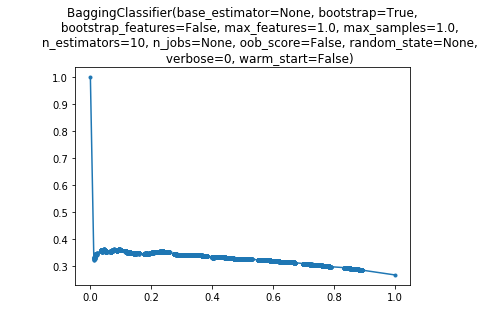

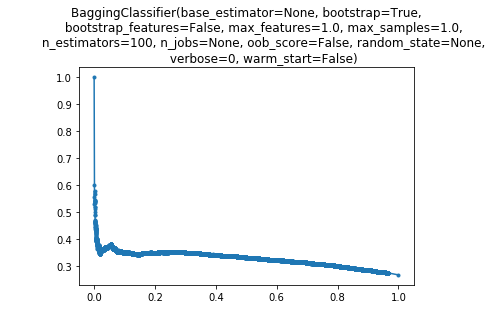

RF


C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


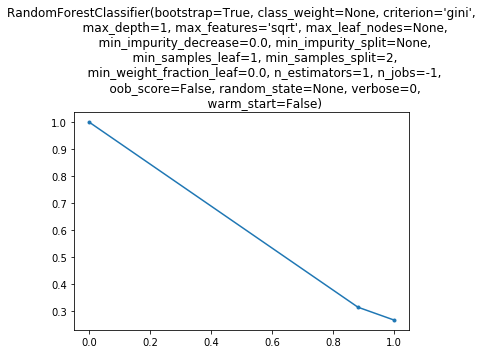

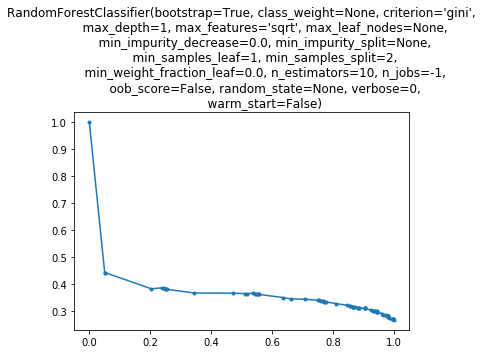

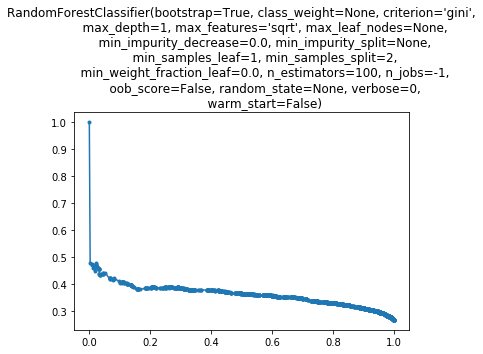

C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


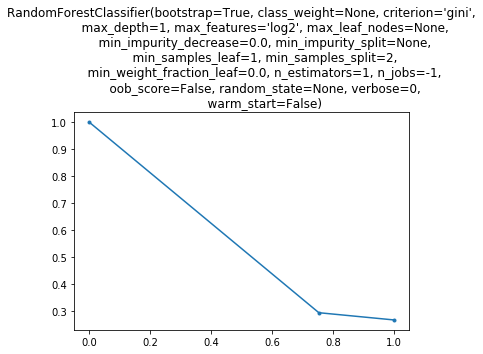

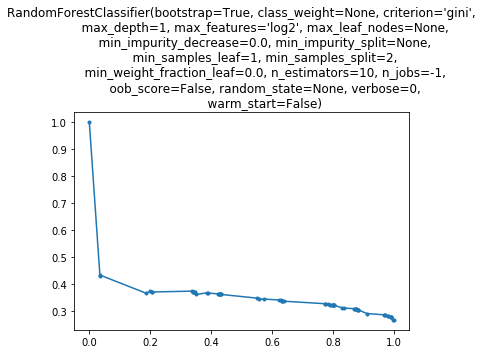

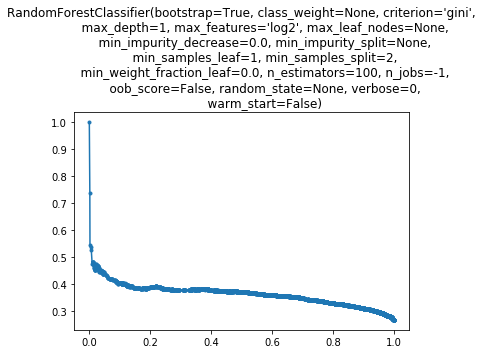

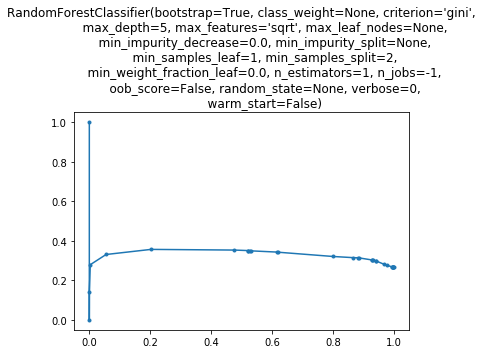

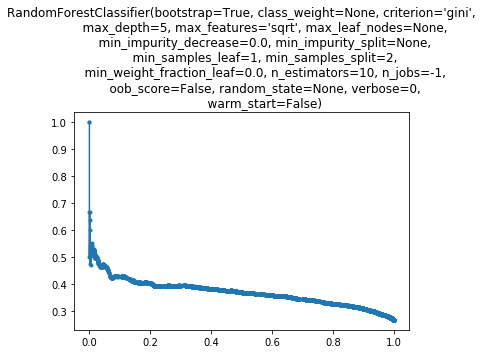

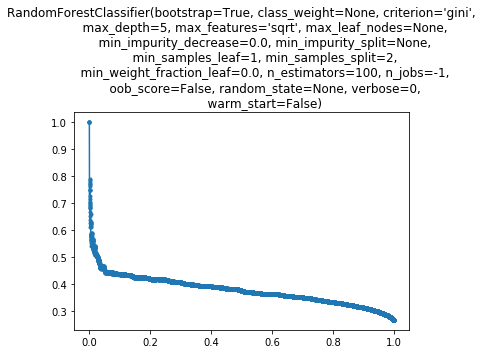

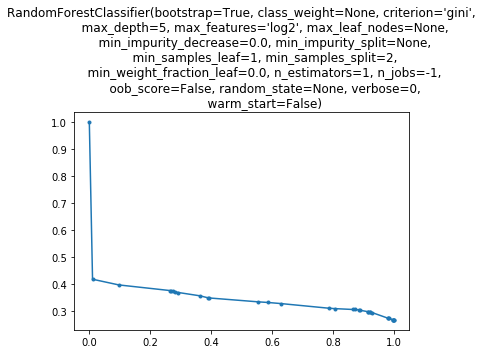

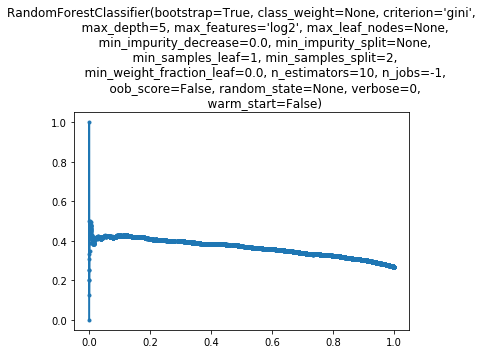

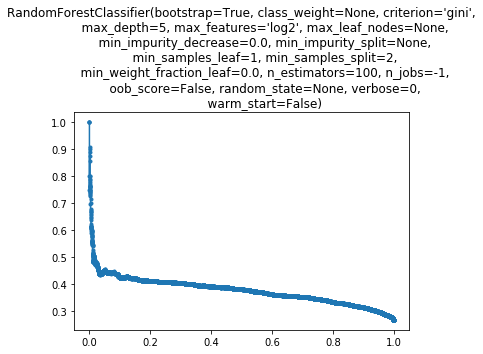

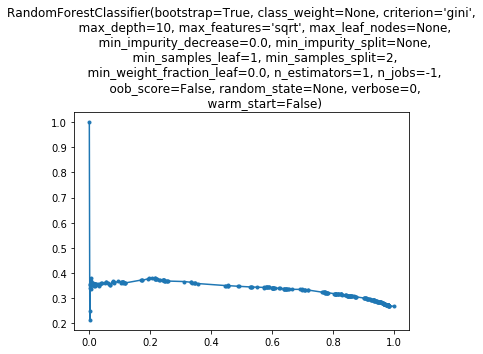

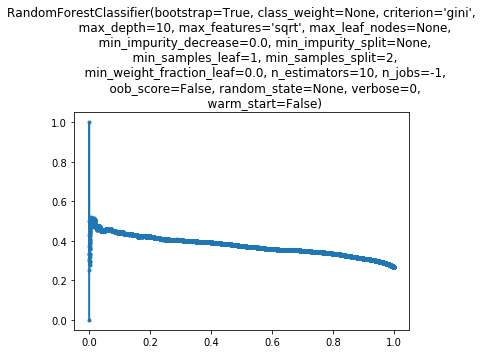

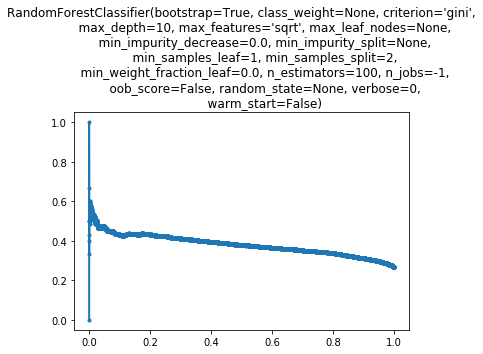

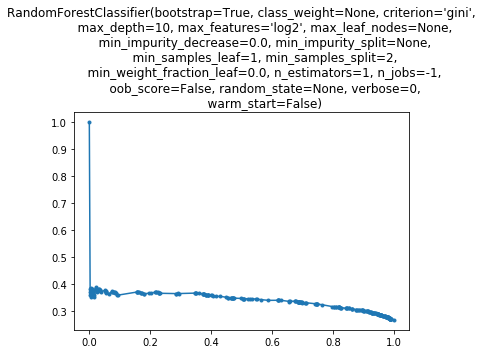

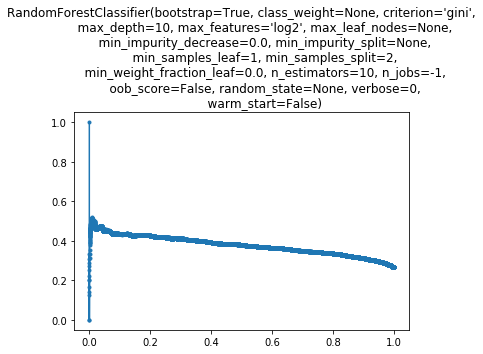

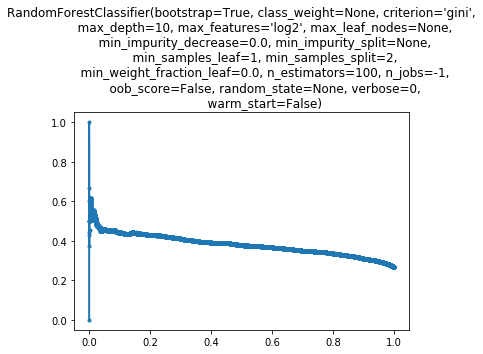

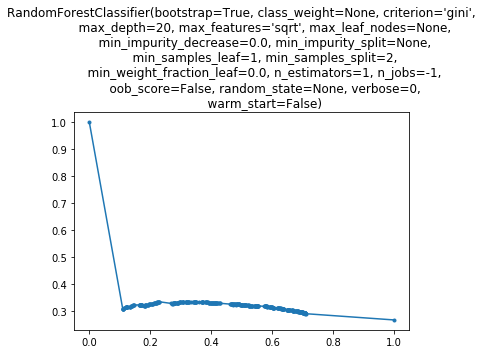

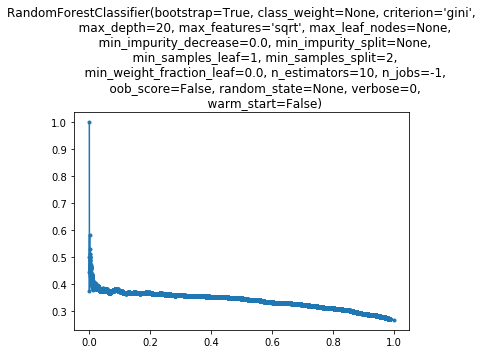

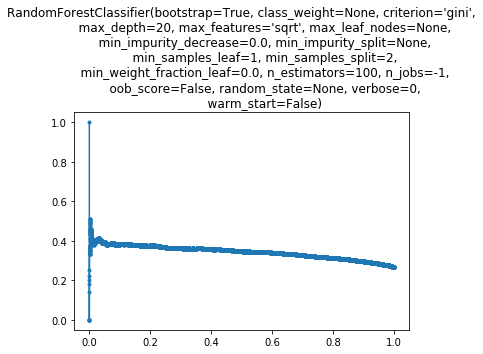

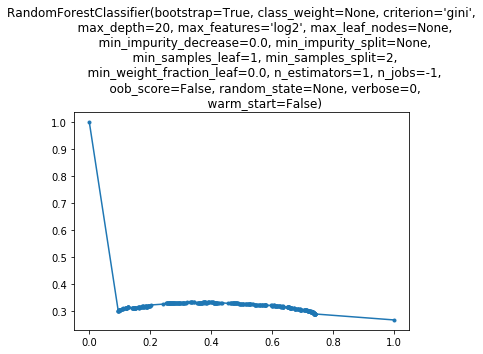

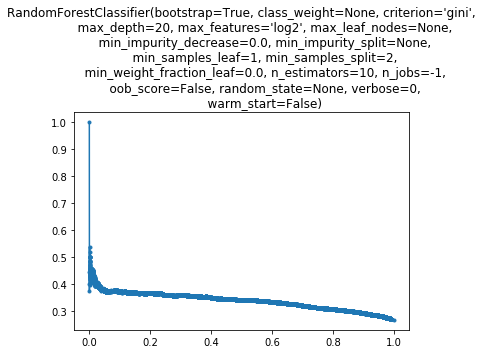

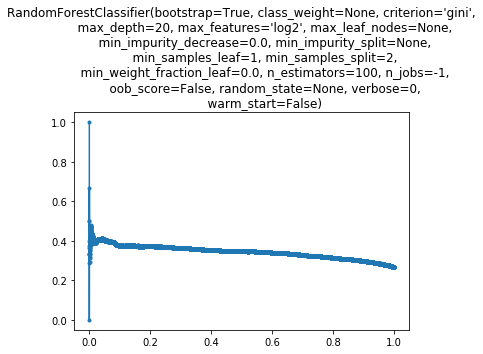

LR


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


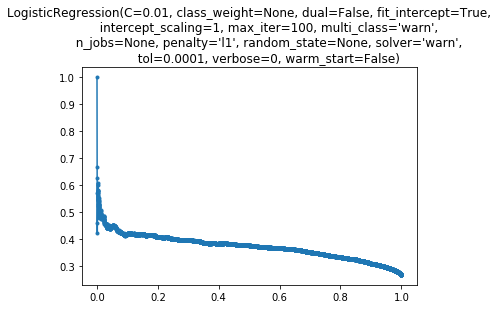

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


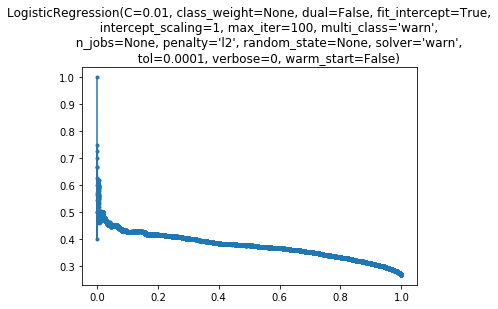

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


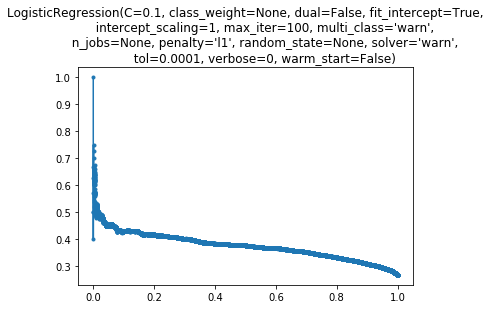

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


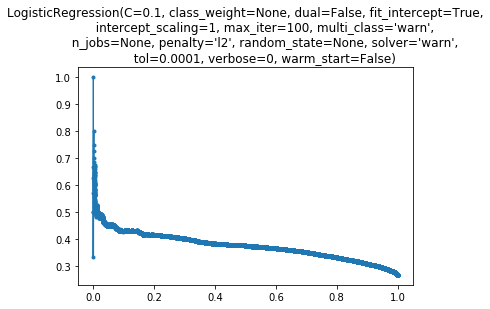

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


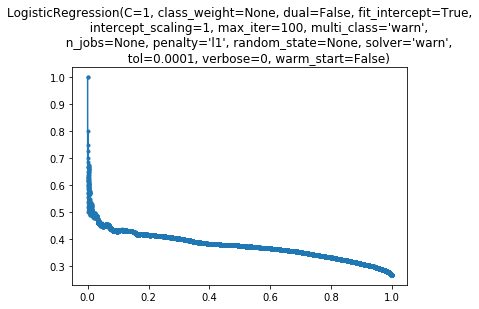

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


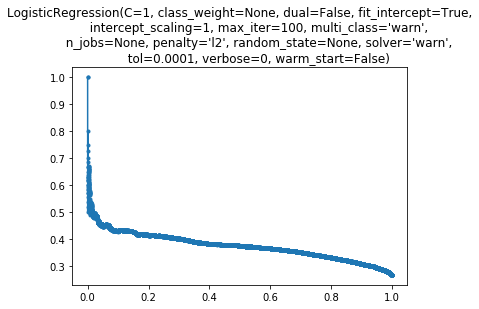

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


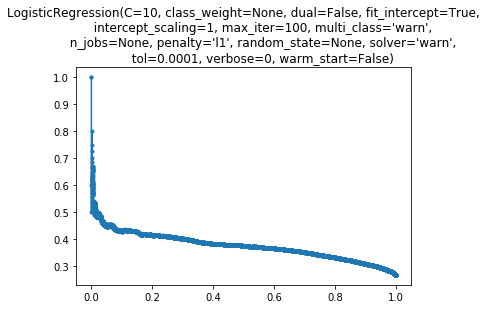

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


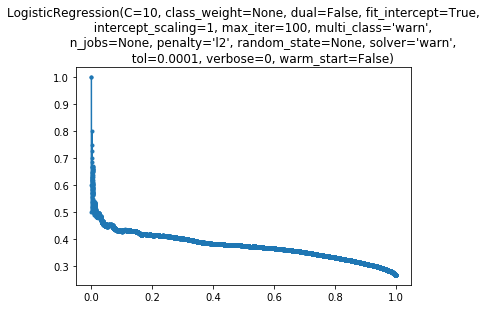

SVM


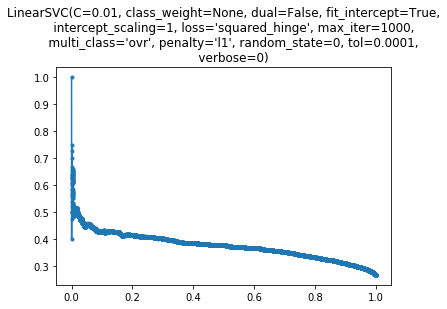

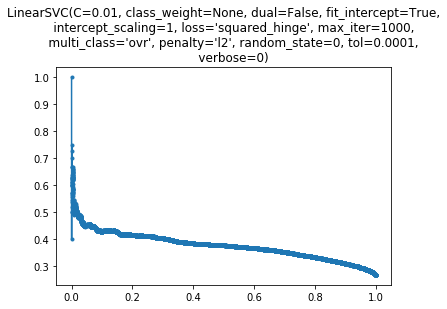

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


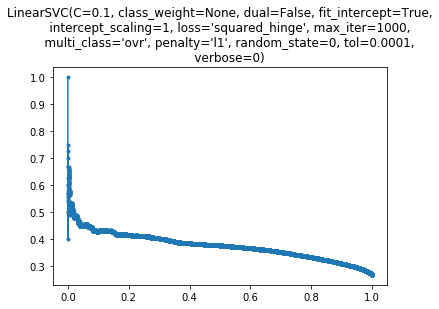

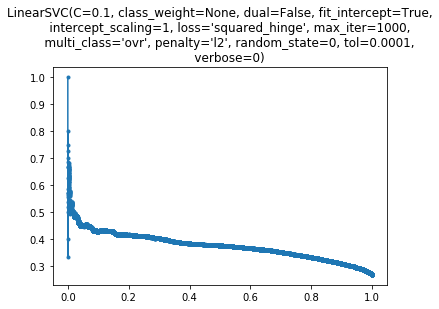

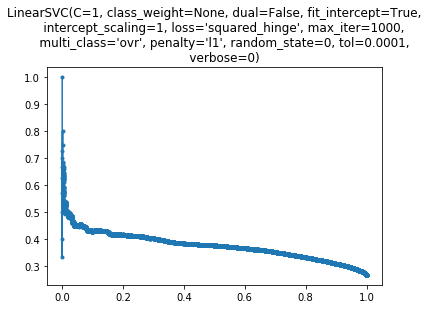

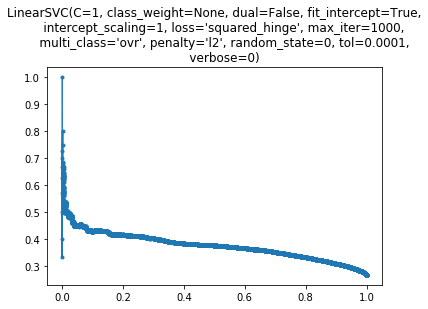

GB


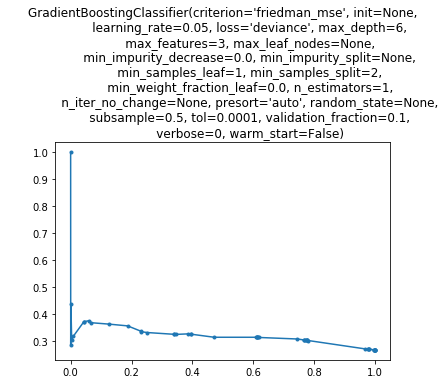

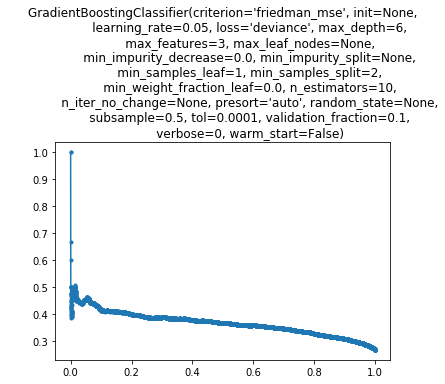

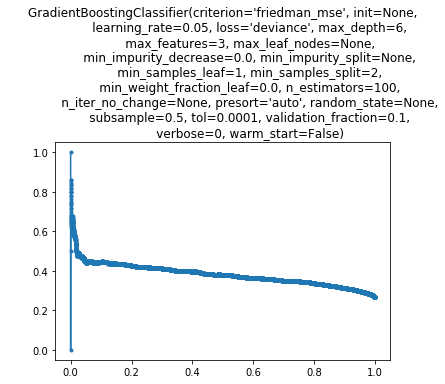

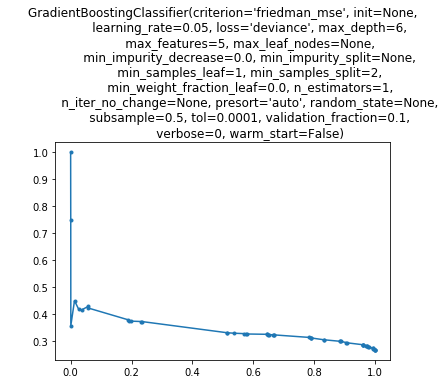

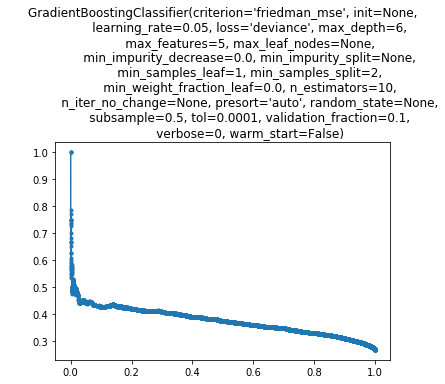

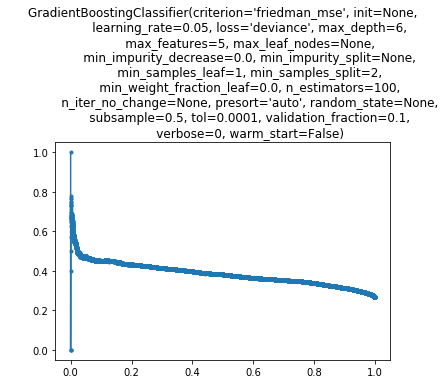

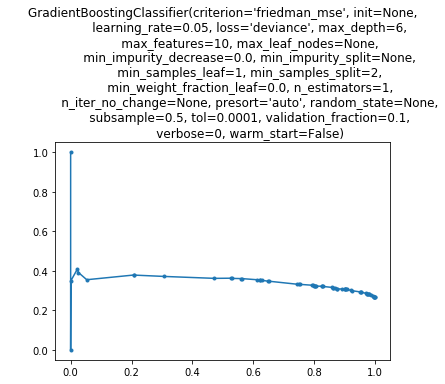

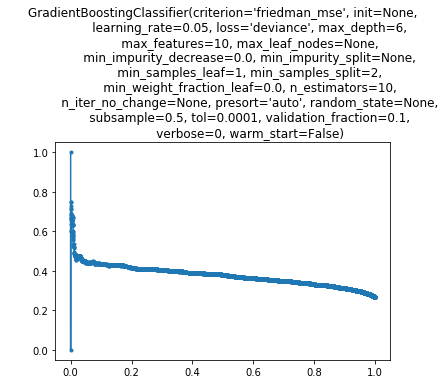

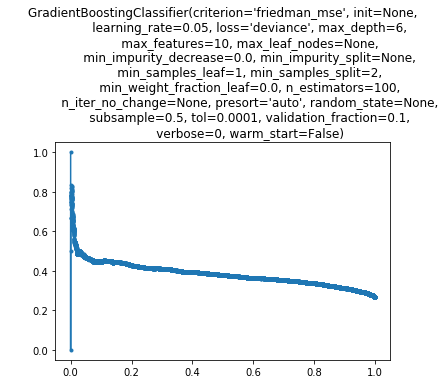

DT


C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


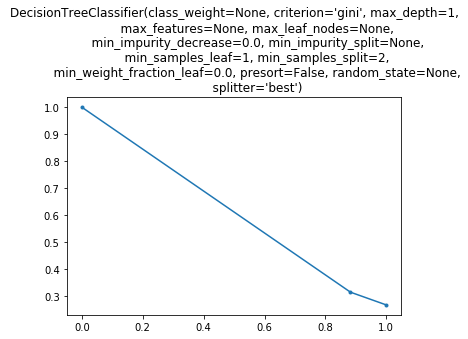

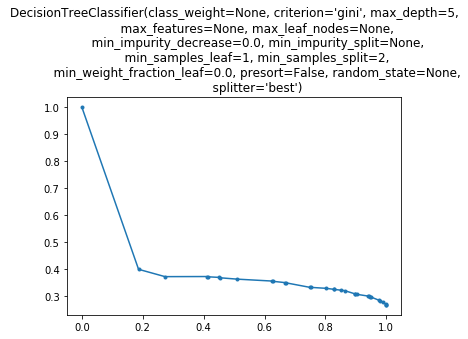

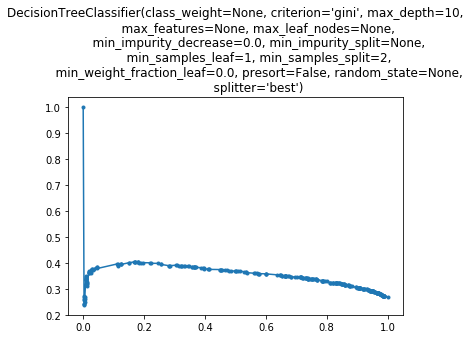

C:\Users\peter\Desktop\MLHW3\hw3_pipeline.py:248: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


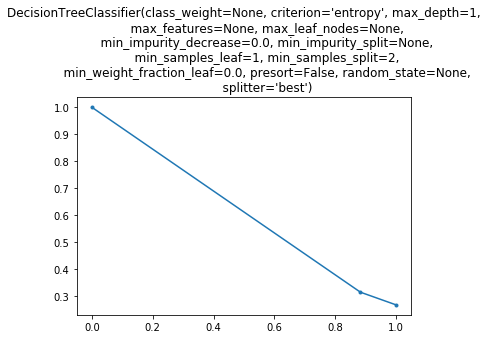

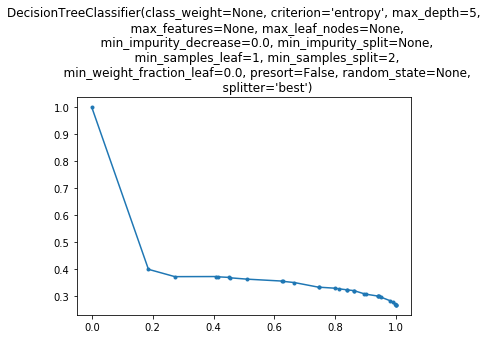

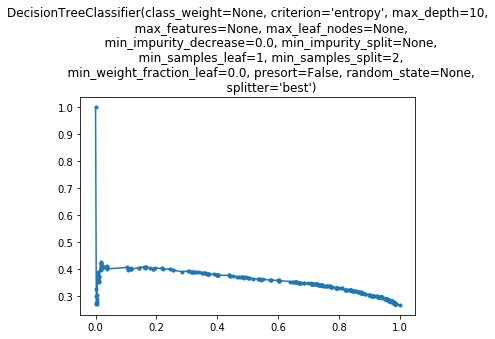

KNN


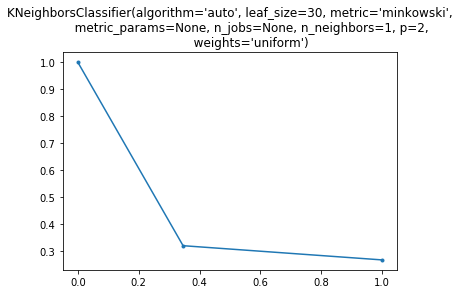

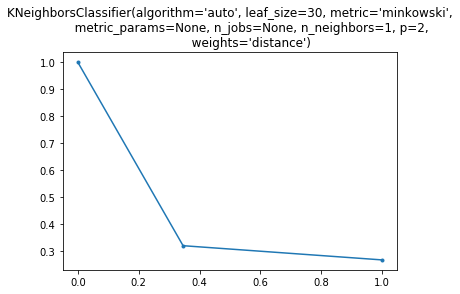

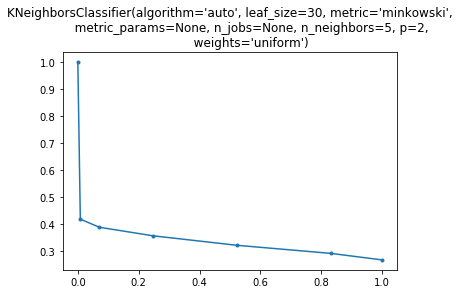

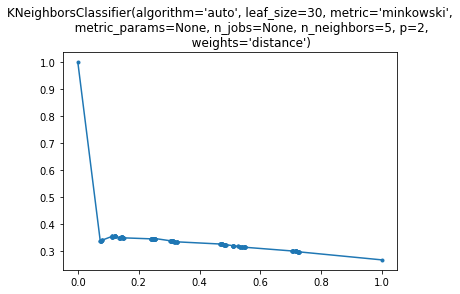

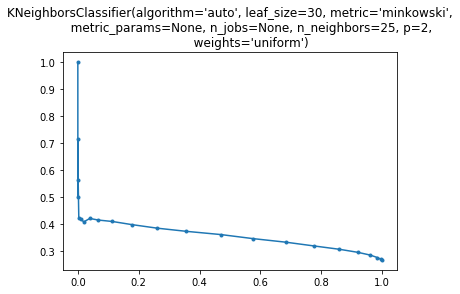

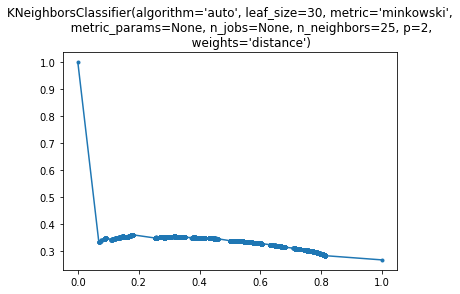

NB


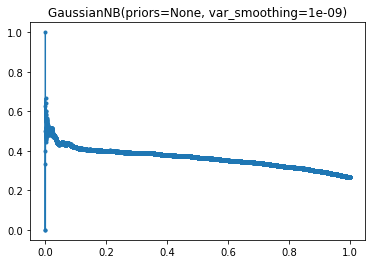

In [49]:
result3 = pipe.clf_loop(models_to_run, clfs, grid, X_train_3, X_test_3, y_train_3, y_test_3)

In [50]:
result3.sort_values(by='auc-roc', ascending=False)

model_type                                                clf  \
45         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
42         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
16         RF  (DecisionTreeClassifier(class_weight=None, cri...   
48         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
19         RF  (DecisionTreeClassifier(class_weight=None, cri...   
18         RF  (DecisionTreeClassifier(class_weight=None, cri...   
13         RF  (DecisionTreeClassifier(class_weight=None, cri...   
10         RF  (DecisionTreeClassifier(class_weight=None, cri...   
47         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
34        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
15         RF  (DecisionTreeClassifier(class_weight=None, cri...   
35        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
36        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
27         LR  LogisticRegression(C=10, class_weight=None, du...   
37        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
38        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
39        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
28         LR  LogisticRegression(C=10, class_weight=None, du...   
29         LR  LogisticRegression(C=10, class_weight=None, du...   
31         LR  LogisticRegression(C=10, class_weight=None, du...   
30         LR  LogisticRegression(C=10, class_weight=None, du...   
26         LR  LogisticRegression(C=10, class_weight=None, du...   
33         LR  LogisticRegression(C=10, class_weight=None, du...   
32         LR  LogisticRegression(C=10, class_weight=None, du...   
44         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
9          RF  (DecisionTreeClassifier(class_weight=None, cri...   
7          RF  (DecisionTreeClassifier(class_weight=None, cri...   
41         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
4          RF  (DecisionTreeClassifier(class_weight=None, cri...   
54         DT  DecisionTreeClassifier(class_weight=None, crit...   
..        ...                                                ...   
3          RF  (DecisionTreeClassifier(class_weight=None, cri...   
50         DT  DecisionTreeClassifier(class_weight=None, crit...   
53         DT  DecisionTreeClassifier(class_weight=None, crit...   
46         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
61         NB       GaussianNB(priors=None, var_smoothing=1e-09)   
59        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
6          RF  (DecisionTreeClassifier(class_weight=None, cri...   
8          RF  (DecisionTreeClassifier(class_weight=None, cri...   
17         RF  (DecisionTreeClassifier(class_weight=None, cri...   
14         RF  (DecisionTreeClassifier(class_weight=None, cri...   
25         RF  (DecisionTreeClassifier(class_weight=None, cri...   
22         RF  (DecisionTreeClassifier(class_weight=None, cri...   
11         RF  (DecisionTreeClassifier(class_weight=None, cri...   
21         RF  (DecisionTreeClassifier(class_weight=None, cri...   
24         RF  (DecisionTreeClassifier(class_weight=None, cri...   
43         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
1          BG  (DecisionTreeClassifier(class_weight=None, cri...   
2          RF  (DecisionTreeClassifier(class_weight=None, cri...   
52         DT  DecisionTreeClassifier(class_weight=None, crit...   
49         DT  DecisionTreeClassifier(class_weight=None, crit...   
60        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
0          BG  (DecisionTreeClassifier(class_weight=None, cri...   
57        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
40         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
58        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
23         RF  (DecisionTreeClassifier(class_weight=None, cri...   
20         RF  (DecisionTreeClassifier(class_weight=None, c

In [51]:
result3.sort_values(by='p_at_5', ascending=False)

model_type                                                clf  \
19         RF  (DecisionTreeClassifier(class_weight=None, cri...   
45         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
48         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
15         RF  (DecisionTreeClassifier(class_weight=None, cri...   
42         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
16         RF  (DecisionTreeClassifier(class_weight=None, cri...   
13         RF  (DecisionTreeClassifier(class_weight=None, cri...   
10         RF  (DecisionTreeClassifier(class_weight=None, cri...   
35        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
38        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
37        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
41         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
39        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
27         LR  LogisticRegression(C=10, class_weight=None, du...   
29         LR  LogisticRegression(C=10, class_weight=None, du...   
32         LR  LogisticRegression(C=10, class_weight=None, du...   
18         RF  (DecisionTreeClassifier(class_weight=None, cri...   
36        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
47         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
33         LR  LogisticRegression(C=10, class_weight=None, du...   
31         LR  LogisticRegression(C=10, class_weight=None, du...   
30         LR  LogisticRegression(C=10, class_weight=None, du...   
34        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
28         LR  LogisticRegression(C=10, class_weight=None, du...   
44         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
61         NB       GaussianNB(priors=None, var_smoothing=1e-09)   
26         LR  LogisticRegression(C=10, class_weight=None, du...   
9          RF  (DecisionTreeClassifier(class_weight=None, cri...   
12         RF  (DecisionTreeClassifier(class_weight=None, cri...   
4          RF  (DecisionTreeClassifier(class_weight=None, cri...   
..        ...                                                ...   
22         RF  (DecisionTreeClassifier(class_weight=None, cri...   
57        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
24         RF  (DecisionTreeClassifier(class_weight=None, cri...   
21         RF  (DecisionTreeClassifier(class_weight=None, cri...   
1          BG  (DecisionTreeClassifier(class_weight=None, cri...   
59        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
40         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
0          BG  (DecisionTreeClassifier(class_weight=None, cri...   
14         RF  (DecisionTreeClassifier(class_weight=None, cri...   
17         RF  (DecisionTreeClassifier(class_weight=None, cri...   
11         RF  (DecisionTreeClassifier(class_weight=None, cri...   
43         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
60        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
8          RF  (DecisionTreeClassifier(class_weight=None, cri...   
58        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
46         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
3          RF  (DecisionTreeClassifier(class_weight=None, cri...   
54         DT  DecisionTreeClassifier(class_weight=None, crit...   
51         DT  DecisionTreeClassifier(class_weight=None, crit...   
6          RF  (DecisionTreeClassifier(class_weight=None, cri...   
23         RF  (DecisionTreeClassifier(class_weight=None, cri...   
20         RF  (DecisionTreeClassifier(class_weight=None, cri...   
50         DT  DecisionTreeClassifier(class_weight=None, crit...   
53         DT  DecisionTreeClassifier(class_weight=None, crit...   
55        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
56        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
52         DT  DecisionTreeClassifier(class_weight=None, cr

In [53]:
result3.sort_values(by='f1_at_5', ascending=False)

model_type                                                clf  \
19         RF  (DecisionTreeClassifier(class_weight=None, cri...   
45         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
48         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
15         RF  (DecisionTreeClassifier(class_weight=None, cri...   
42         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
16         RF  (DecisionTreeClassifier(class_weight=None, cri...   
13         RF  (DecisionTreeClassifier(class_weight=None, cri...   
10         RF  (DecisionTreeClassifier(class_weight=None, cri...   
35        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
37        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
38        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
41         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
27         LR  LogisticRegression(C=10, class_weight=None, du...   
39        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
36        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
18         RF  (DecisionTreeClassifier(class_weight=None, cri...   
29         LR  LogisticRegression(C=10, class_weight=None, du...   
32         LR  LogisticRegression(C=10, class_weight=None, du...   
47         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
33         LR  LogisticRegression(C=10, class_weight=None, du...   
31         LR  LogisticRegression(C=10, class_weight=None, du...   
30         LR  LogisticRegression(C=10, class_weight=None, du...   
34        SVM  LinearSVC(C=1, class_weight=None, dual=False, ...   
28         LR  LogisticRegression(C=10, class_weight=None, du...   
44         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
61         NB       GaussianNB(priors=None, var_smoothing=1e-09)   
26         LR  LogisticRegression(C=10, class_weight=None, du...   
9          RF  (DecisionTreeClassifier(class_weight=None, cri...   
12         RF  (DecisionTreeClassifier(class_weight=None, cri...   
4          RF  (DecisionTreeClassifier(class_weight=None, cri...   
..        ...                                                ...   
22         RF  (DecisionTreeClassifier(class_weight=None, cri...   
57        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
24         RF  (DecisionTreeClassifier(class_weight=None, cri...   
21         RF  (DecisionTreeClassifier(class_weight=None, cri...   
1          BG  (DecisionTreeClassifier(class_weight=None, cri...   
59        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
40         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
0          BG  (DecisionTreeClassifier(class_weight=None, cri...   
14         RF  (DecisionTreeClassifier(class_weight=None, cri...   
17         RF  (DecisionTreeClassifier(class_weight=None, cri...   
11         RF  (DecisionTreeClassifier(class_weight=None, cri...   
43         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
60        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
8          RF  (DecisionTreeClassifier(class_weight=None, cri...   
58        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
46         GB  ([DecisionTreeRegressor(criterion='friedman_ms...   
3          RF  (DecisionTreeClassifier(class_weight=None, cri...   
54         DT  DecisionTreeClassifier(class_weight=None, crit...   
51         DT  DecisionTreeClassifier(class_weight=None, crit...   
6          RF  (DecisionTreeClassifier(class_weight=None, cri...   
23         RF  (DecisionTreeClassifier(class_weight=None, cri...   
20         RF  (DecisionTreeClassifier(class_weight=None, cri...   
50         DT  DecisionTreeClassifier(class_weight=None, crit...   
55        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
56        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
53         DT  DecisionTreeClassifier(class_weight=None, crit...   
2          RF  (DecisionTreeClassifier(class_weight=None, c